In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import plotting_extent
from natsort import natsorted
import gdal
import pandas as pd
import numpy as np
import geopandas
import rasterio
import pycrs

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/concept proof'

In [25]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/spec_filtered/taxa.txt",header=None)
taxa.columns=["taxon"]

species_occ_dict={}

for i in taxa["taxon"]:
    taxon_data = pd.read_csv(file_dir+"/data/spec_filtered/%s.csv"%i)
    #add species dataframe to dict
    species_occ_dict["%s"%i] = taxon_data  
    #check whether all species have been included and inspect dictionary
if len(species_occ_dict.keys())==len(taxa["taxon"]):
    print("All species dataframes now in dictionary")
else:
    print("Error: not all species dataframe included")

All species dataframes now in dictionary


#### Part 1
- First read in occurrence data
- Create a copy that we can use in the original state later
- Create a buffer around each occurrence point, merge it into a single polygon
- Clip the environmental raster based on this extend

In [5]:
for key in species_occ_dict:    
    #load occurrence data and set initial projection
    data=species_occ_dict[key]
    print(data.columns)
    spec = key


    data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    data["present/pseudo_absent"]=1
    geo_data=geopandas.GeoDataFrame(data, geometry='coordinates',crs={'init' :'epsg:4326'})

    #change projection to azimuthal equidistant to calculate 1000km buffer around point
    geo_data = geo_data.to_crs({'init': 'esri:54032'}) 
    buffer=geo_data.buffer(1000*1000)
    buffer=buffer.to_crs(epsg=4326)

    #create single large polygon from individual buffers
    union_buffer=buffer.unary_union

    #first clip the raster based on this extend 
    raster=rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
    #specify output tif:
    out_tif = file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec

    #clip the raster:
    out_img, out_transform = mask(dataset=raster, shapes=[union_buffer],crop=True)
   
    # Copy the metadata
    out_meta = raster.meta.copy()

    # Parse EPSG code
    epsg_code = int(raster.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_img)

Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude',
       'coordinates', 'present/pseudo_absent'],
      dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude',
       'coordinates', 'present/pseudo_absent'],
      dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude',
       'coordinates', 'present/pseudo_absent'],
      dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude',
       'coordinates', 'present/pseudo_absent'],
      dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude',
       'coordinates', 'present/pseudo_absent'],
      dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude',
       'coordinates', 'present/pseudo_absent'],
      dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude',
       'coordinates', 'present/pseudo_absent'],
      dtype='object')

Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gbif_id', 'taxon_name', 'decimal_latitude', 'decimal_longitude'], dtype='object')
Index(['gb

Inspect whether clip was correct

In [ ]:
#Inspect the first band of the clipped raster for all species
for key in species_occ_dict:
    ##### Extract occurrence point to plot on the raster (see if correct area was clipped)
    data=species_occ_dict[key]
    print(len(data.index))
    spec = key
    data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    geo_data=geopandas.GeoDataFrame(data, geometry='coordinates',crs={'init' :'epsg:4326'})
    ####open the clipped raster
    clipped = rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array = clipped.read(1)
    array_data = clipped.read(1,masked=True)
    array_meta = clipped.profile
   
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array_data,cmap="gist_earth",interpolation="none",vmin=0,
    # Here you must set the spatial extent or else the data will not line up with your geopandas layer
    extent=plotting_extent(clipped),)
    spec_plots_points=geo_data["coordinates"]
    spec_plots_points.plot(ax=ax,
                       marker='o',
                       markersize=20,
                       color='red')
    ax.set_title("%s \n Raster clip and occurrence points"%spec,
             fontsize=20)
    plt.show()
#Works!

#### Part 2
- now that we have the clipped raster we can use it to try and make a random selection of pseudo absence points
- we first open the raster
- then we separate those cells that actually contain pixel values (excluding the sea)
- we calculate the longitude and latitude of the centre point of these cells <br>
  (the environmental variable values do not vary within each cell so it doesn't matter if each points is in the centre)
- we make a random selection of 1000 positions (in line with Hendrix & Vos)
- we add the longitude and latitude values of these to to the dataset and export it  

Text(0.5, 1.0, 'Aepyceros_melampus')

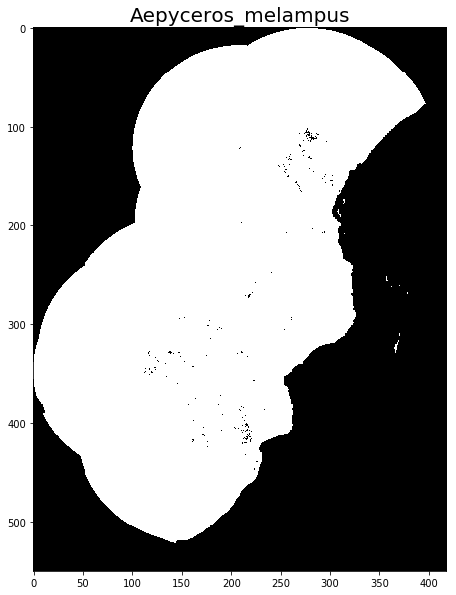

449 number of presences
1000 number of pseudo absences
1449 lenght data with pseudo absences pre-filtering


C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



1432 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Alcelaphus_buselaphus')

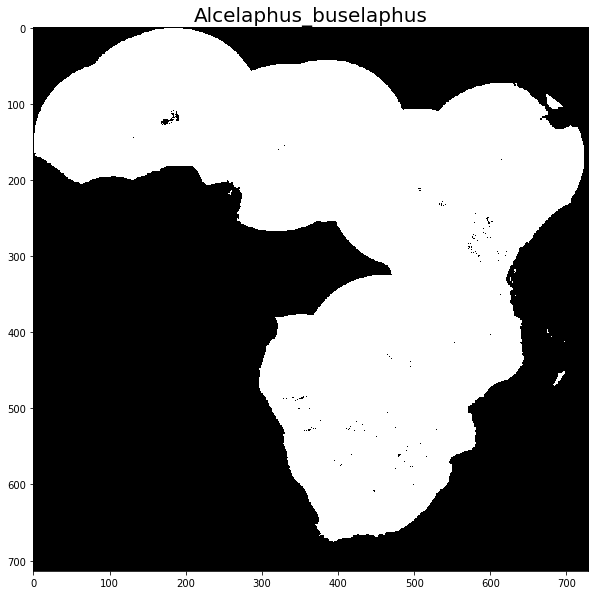

756 number of presences
1000 number of pseudo absences
1756 lenght data with pseudo absences pre-filtering
1753 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Alcelaphus_caama')

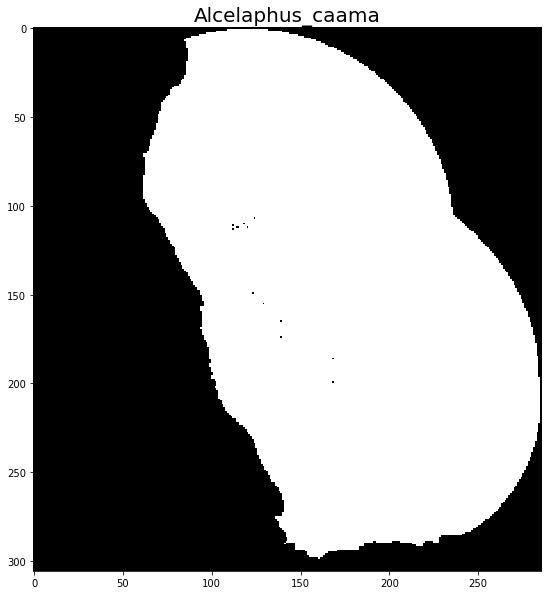

14 number of presences
1000 number of pseudo absences
1014 lenght data with pseudo absences pre-filtering
1014 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Alces_alces')

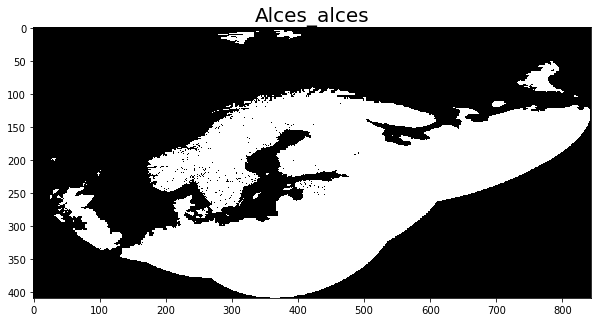

785 number of presences
1000 number of pseudo absences
1785 lenght data with pseudo absences pre-filtering
1733 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Alces_americanus')

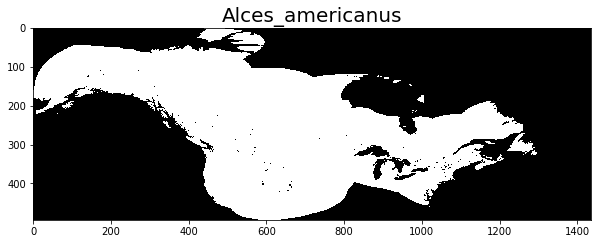

832 number of presences
1000 number of pseudo absences
1832 lenght data with pseudo absences pre-filtering
1786 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ammotragus_lervia')

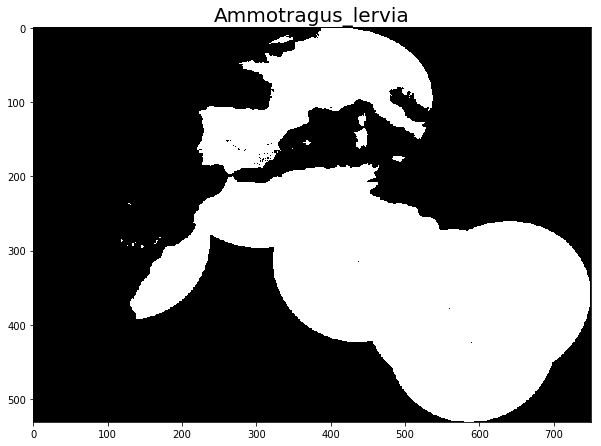

322 number of presences
1000 number of pseudo absences
1322 lenght data with pseudo absences pre-filtering
1318 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Antidorcas_marsupialis')

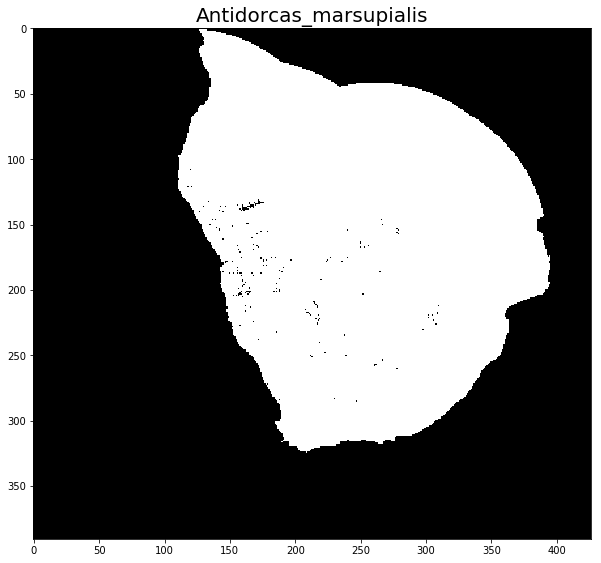

309 number of presences
1000 number of pseudo absences
1309 lenght data with pseudo absences pre-filtering
1308 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Antilocapra_americana')

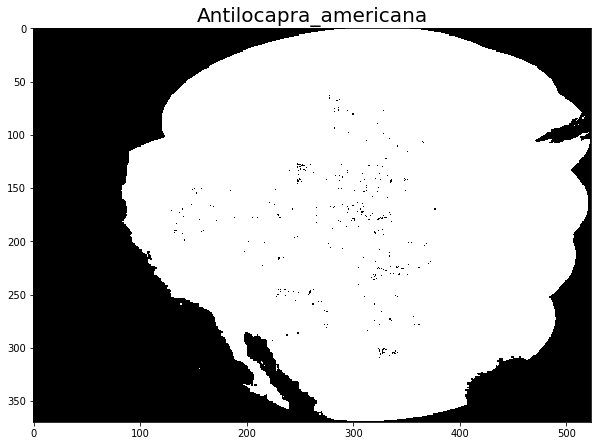

525 number of presences
1000 number of pseudo absences
1525 lenght data with pseudo absences pre-filtering
1519 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Antilope_cervicapra')

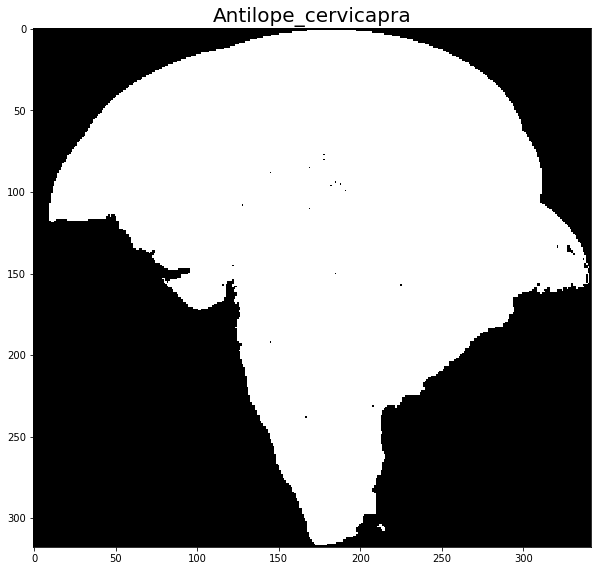

21 number of presences
1000 number of pseudo absences
1021 lenght data with pseudo absences pre-filtering
1021 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Axis_axis')

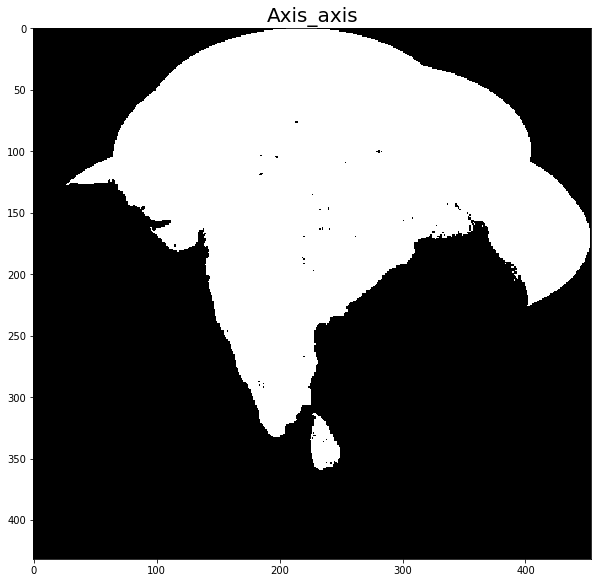

93 number of presences
1000 number of pseudo absences
1093 lenght data with pseudo absences pre-filtering
1084 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Axis_porcinus')

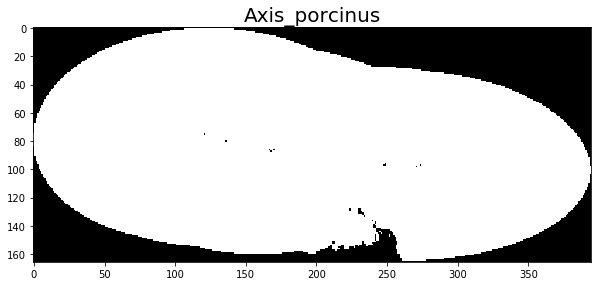

11 number of presences
1000 number of pseudo absences
1011 lenght data with pseudo absences pre-filtering
1011 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Bison_bison')

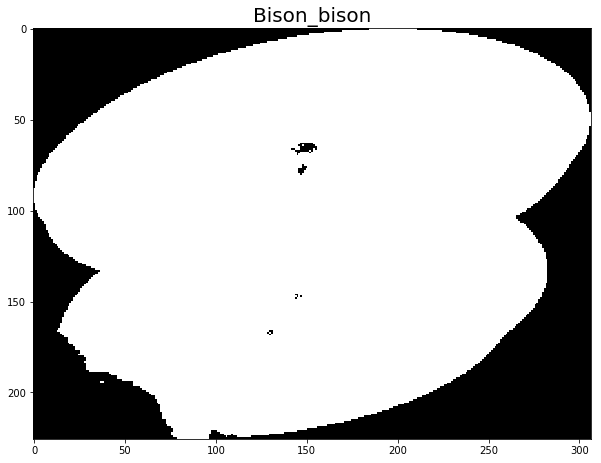

271 number of presences
1000 number of pseudo absences
1271 lenght data with pseudo absences pre-filtering
1271 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Bison_bonasus')

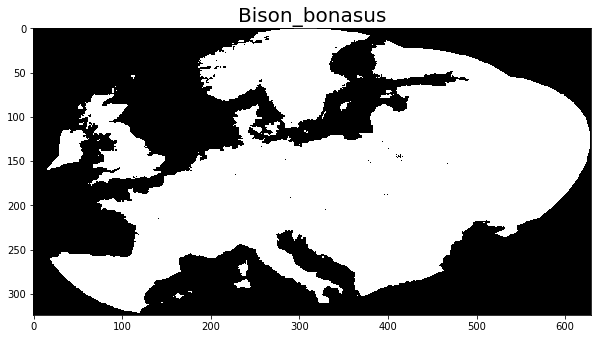

53 number of presences
1000 number of pseudo absences
1053 lenght data with pseudo absences pre-filtering
1049 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Blastocerus_dichotomus')

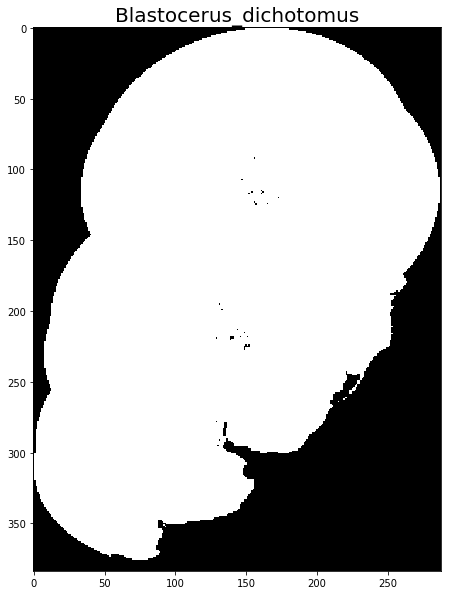

150 number of presences
1000 number of pseudo absences
1150 lenght data with pseudo absences pre-filtering
1149 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Bos_frontalis_gaurus')

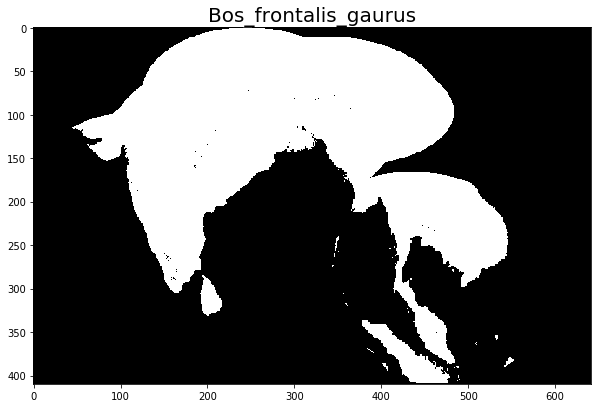

51 number of presences
1000 number of pseudo absences
1051 lenght data with pseudo absences pre-filtering
1051 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Bos_grunniens_mutus')

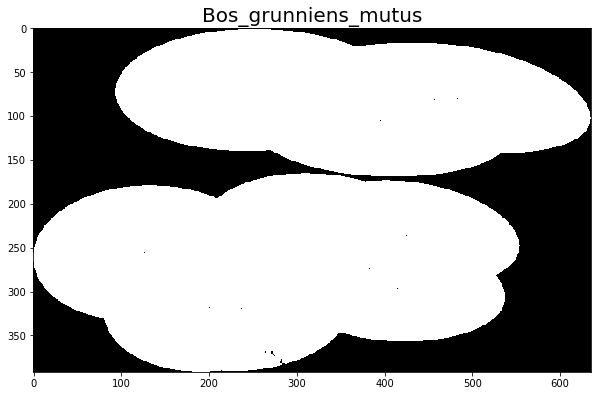

13 number of presences
1000 number of pseudo absences
1013 lenght data with pseudo absences pre-filtering
1012 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Bos_javanicus')

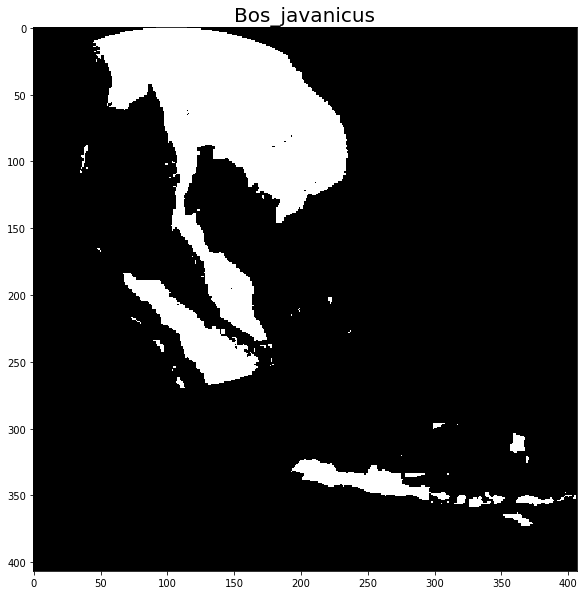

15 number of presences
1000 number of pseudo absences
1015 lenght data with pseudo absences pre-filtering
1012 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Bos_taurus_primigenius')

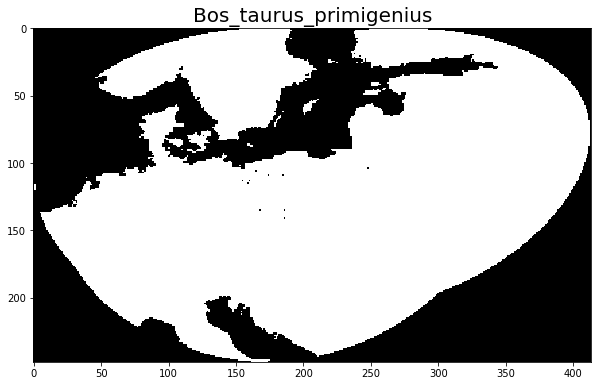

10 number of presences
1000 number of pseudo absences
1010 lenght data with pseudo absences pre-filtering
1005 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Boselaphus_tragocamelus')

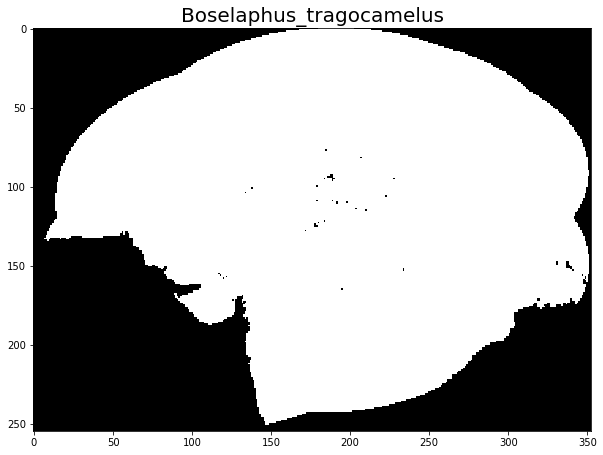

50 number of presences
1000 number of pseudo absences
1050 lenght data with pseudo absences pre-filtering
1050 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Bubalus_bubalis_arnee')

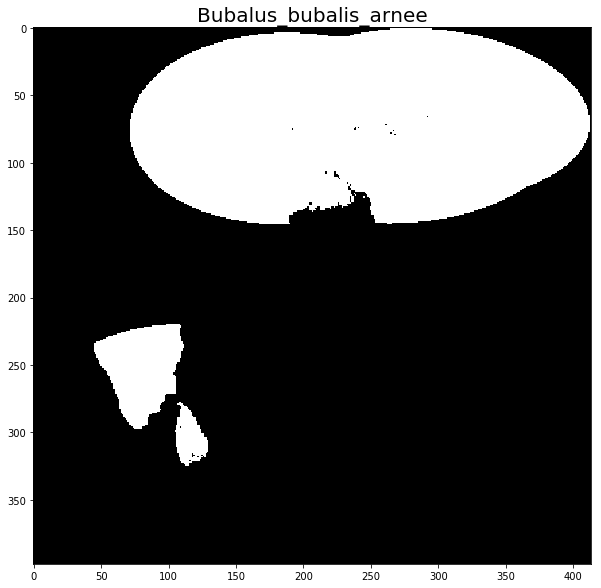

25 number of presences
1000 number of pseudo absences
1025 lenght data with pseudo absences pre-filtering
1024 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Budorcas_taxicolor')

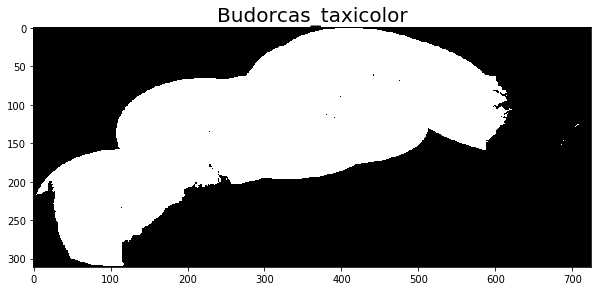

20 number of presences
1000 number of pseudo absences
1020 lenght data with pseudo absences pre-filtering
1020 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Camelus_bactrianus')

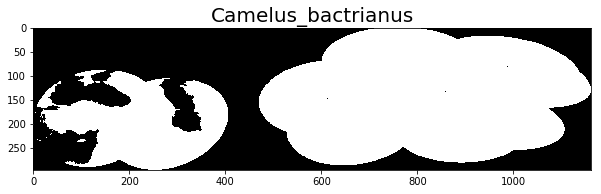

18 number of presences
1000 number of pseudo absences
1018 lenght data with pseudo absences pre-filtering
1015 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Camelus_dromedarius')

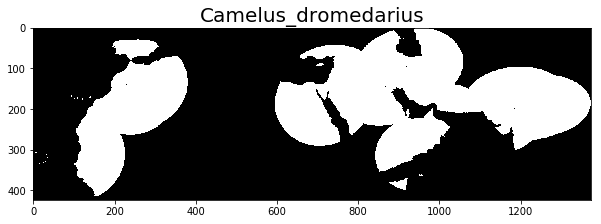

37 number of presences
1000 number of pseudo absences
1037 lenght data with pseudo absences pre-filtering
1030 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capra_hircus_aegagrus')

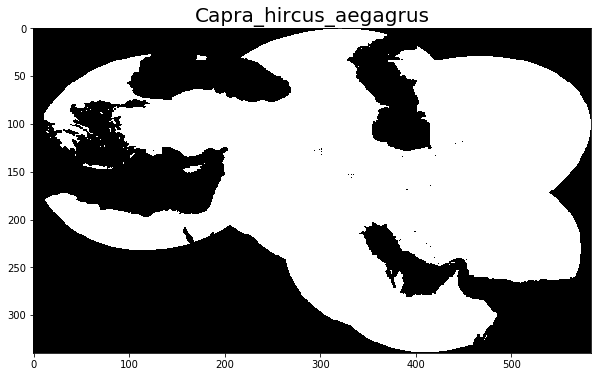

37 number of presences
1000 number of pseudo absences
1037 lenght data with pseudo absences pre-filtering
1035 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capra_ibex')

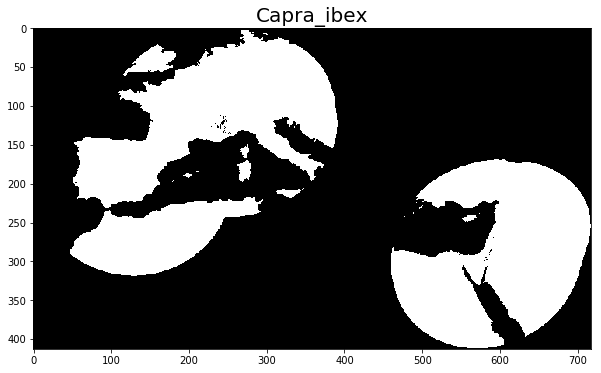

113 number of presences
1000 number of pseudo absences
1113 lenght data with pseudo absences pre-filtering
1108 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capra_nubiana')

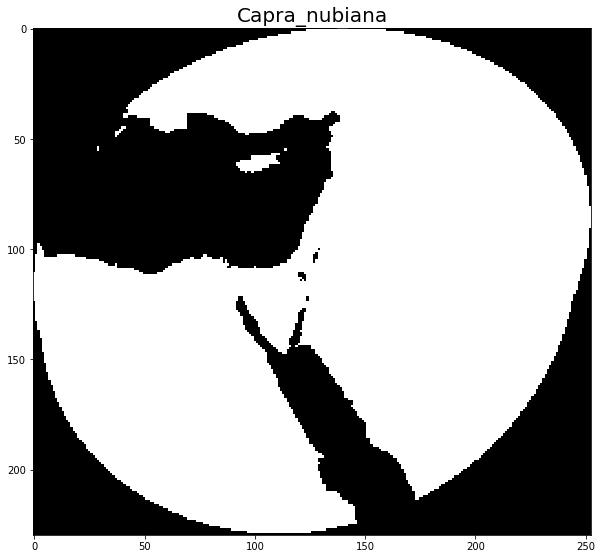

34 number of presences
1000 number of pseudo absences
1034 lenght data with pseudo absences pre-filtering
1032 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capra_pyrenaica')

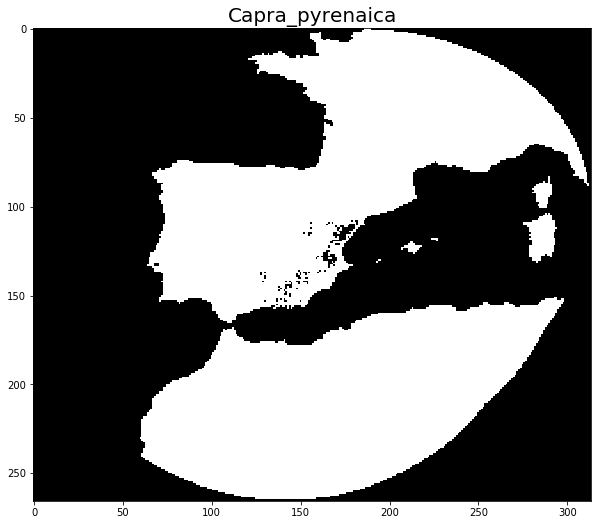

311 number of presences
1000 number of pseudo absences
1311 lenght data with pseudo absences pre-filtering
1310 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capra_sibirica')

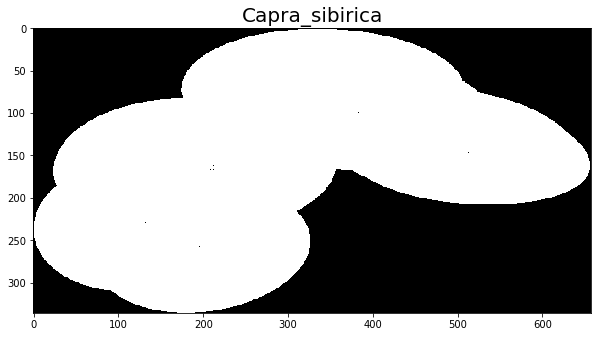

13 number of presences
1000 number of pseudo absences
1013 lenght data with pseudo absences pre-filtering
1010 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capreolus_capreolus')

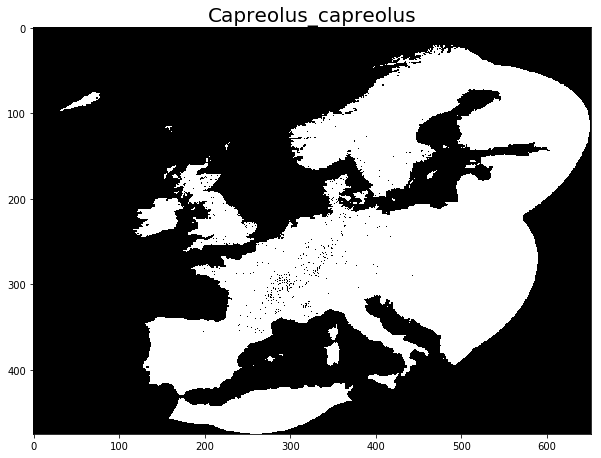

686 number of presences
1000 number of pseudo absences
1686 lenght data with pseudo absences pre-filtering
1642 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capreolus_pygargus')

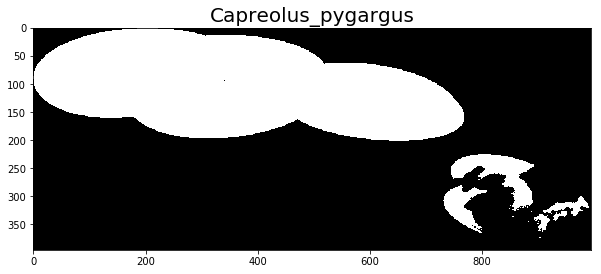

18 number of presences
1000 number of pseudo absences
1018 lenght data with pseudo absences pre-filtering
1014 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capricornis_crispus')

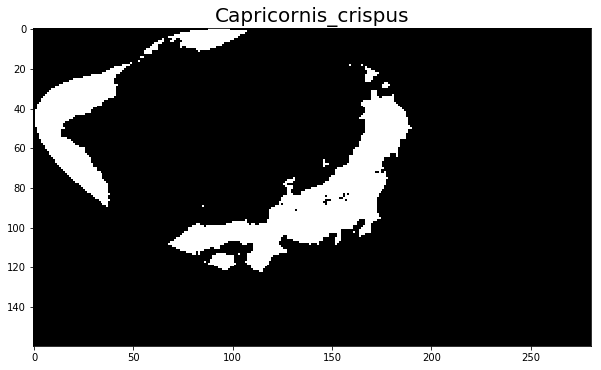

43 number of presences
1000 number of pseudo absences
1043 lenght data with pseudo absences pre-filtering
1043 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Capricornis_swinhoei')

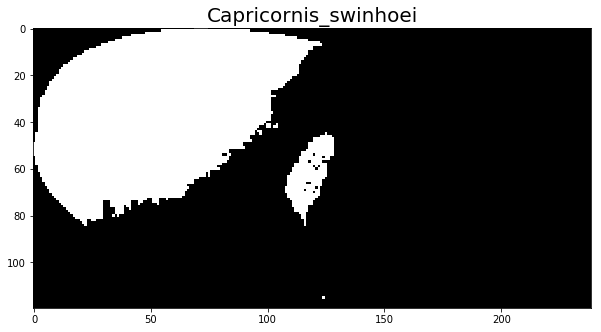

21 number of presences
1000 number of pseudo absences
1021 lenght data with pseudo absences pre-filtering
1021 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Catagonus_wagneri')

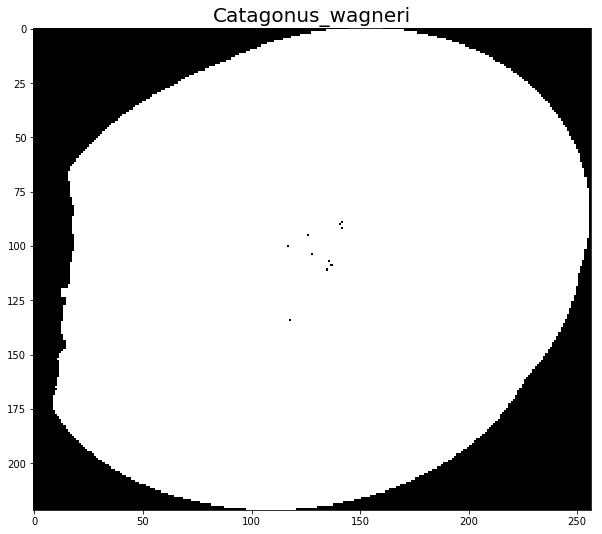

10 number of presences
1000 number of pseudo absences
1010 lenght data with pseudo absences pre-filtering
1010 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cephalophus_dorsalis')

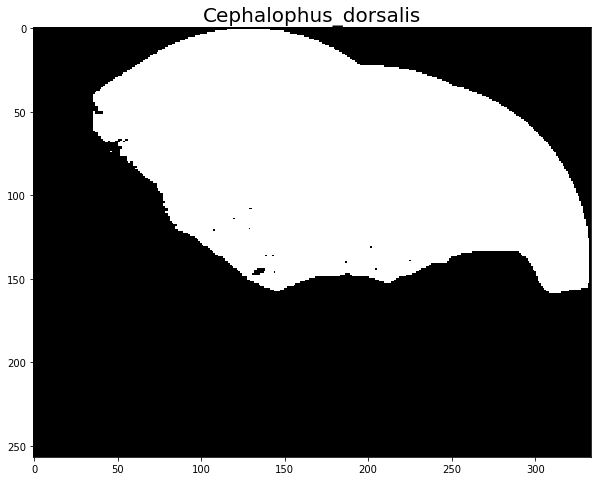

259 number of presences
1000 number of pseudo absences
1259 lenght data with pseudo absences pre-filtering
1258 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cephalophus_jentinki')

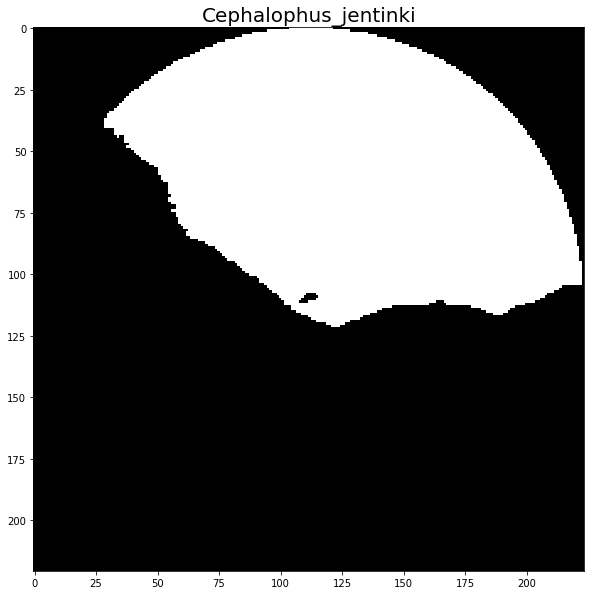

100 number of presences
1000 number of pseudo absences
1100 lenght data with pseudo absences pre-filtering
1099 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cephalophus_natalensis')

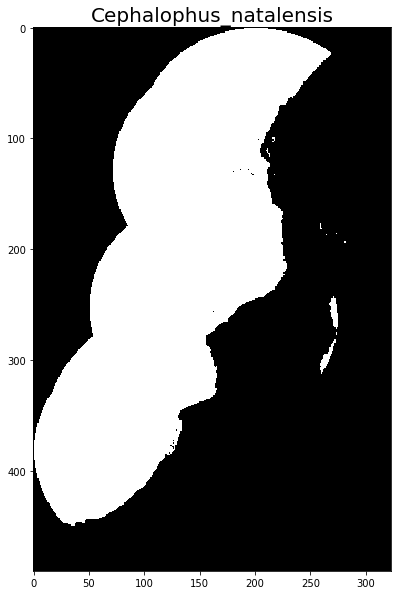

56 number of presences
1000 number of pseudo absences
1056 lenght data with pseudo absences pre-filtering
1024 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cephalophus_niger')

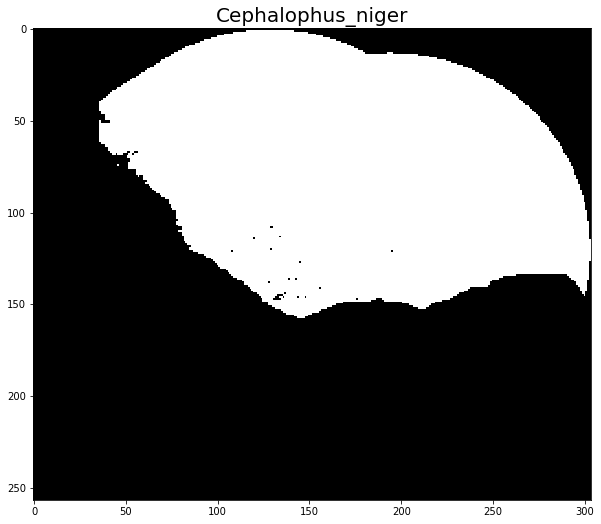

35 number of presences
1000 number of pseudo absences
1035 lenght data with pseudo absences pre-filtering
1035 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cephalophus_nigrifrons')

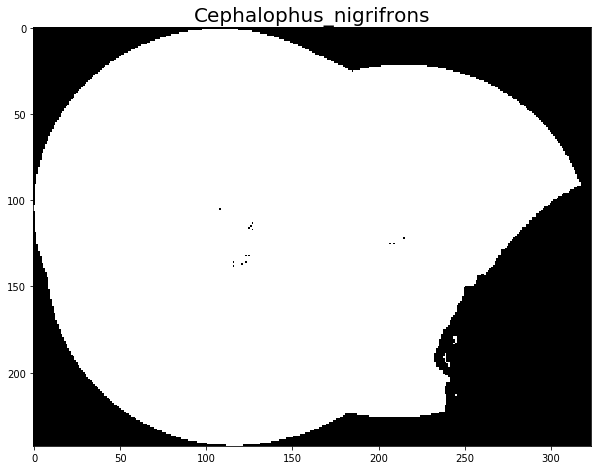

18 number of presences
1000 number of pseudo absences
1018 lenght data with pseudo absences pre-filtering
996 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cephalophus_rufilatus')

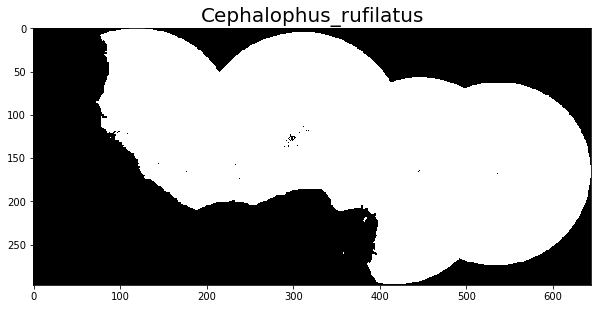

156 number of presences
1000 number of pseudo absences
1156 lenght data with pseudo absences pre-filtering
1156 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cephalophus_silvicultor')

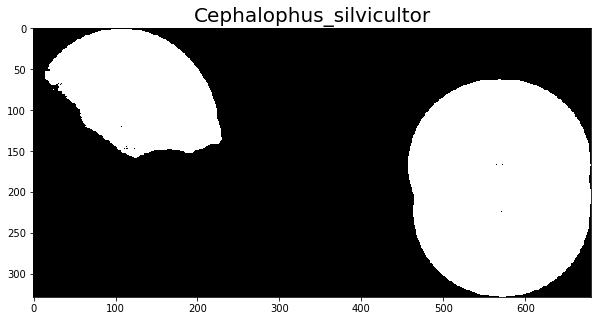

28 number of presences
1000 number of pseudo absences
1028 lenght data with pseudo absences pre-filtering
1012 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cephalophus_zebra')

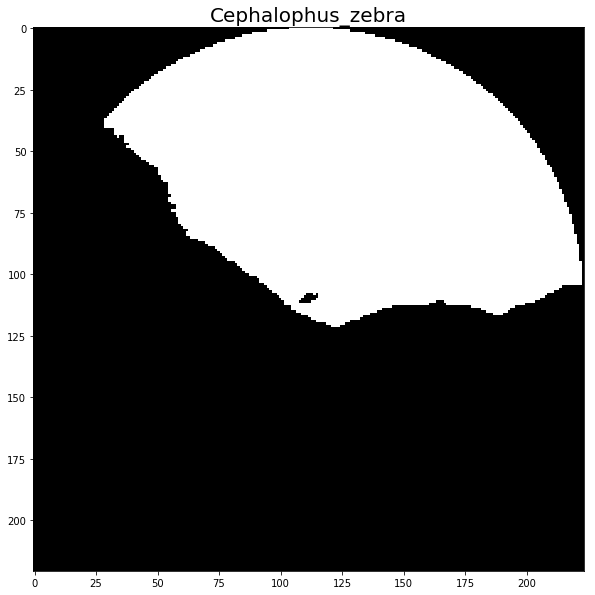

145 number of presences
1000 number of pseudo absences
1145 lenght data with pseudo absences pre-filtering
1144 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ceratotherium_simum')

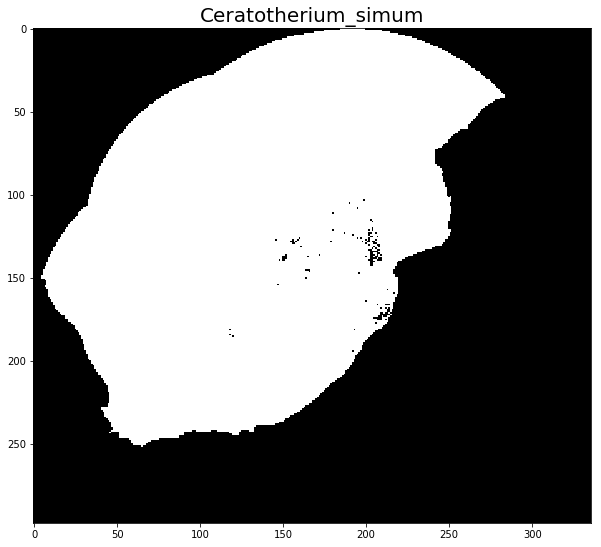

267 number of presences
1000 number of pseudo absences
1267 lenght data with pseudo absences pre-filtering
1260 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cervus_elaphus')

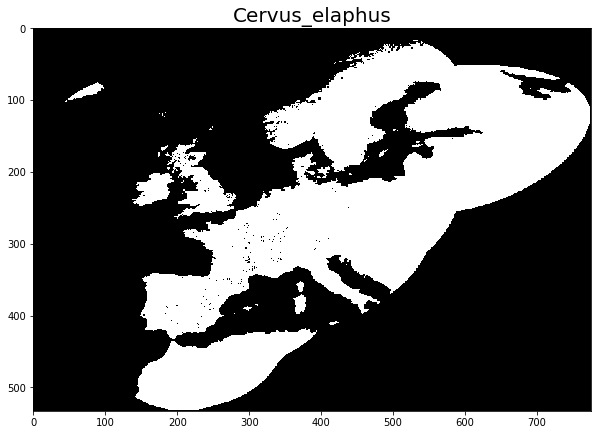

584 number of presences
1000 number of pseudo absences
1584 lenght data with pseudo absences pre-filtering
1545 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Cervus_nippon')

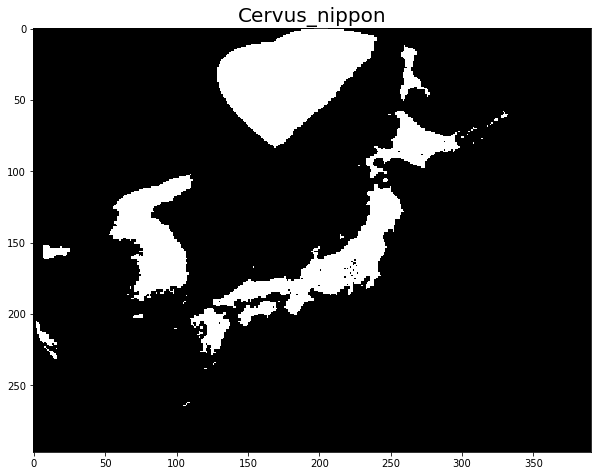

40 number of presences
1000 number of pseudo absences
1040 lenght data with pseudo absences pre-filtering
1037 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Connochaetes_gnou')

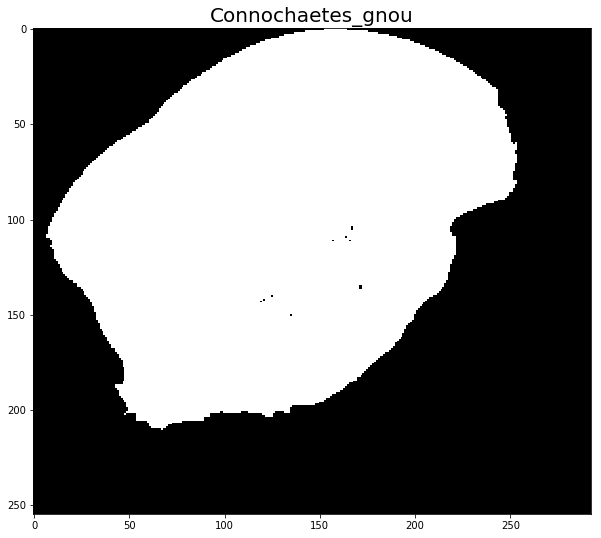

35 number of presences
1000 number of pseudo absences
1035 lenght data with pseudo absences pre-filtering
1035 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Connochaetes_taurinus')

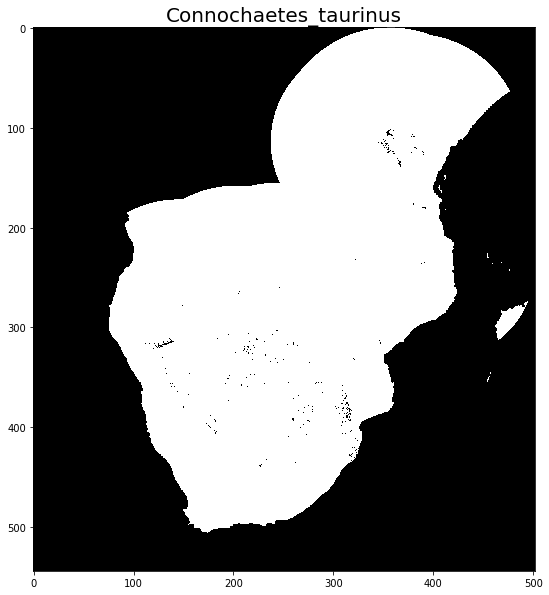

532 number of presences
1000 number of pseudo absences
1532 lenght data with pseudo absences pre-filtering
1513 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Dama_dama')

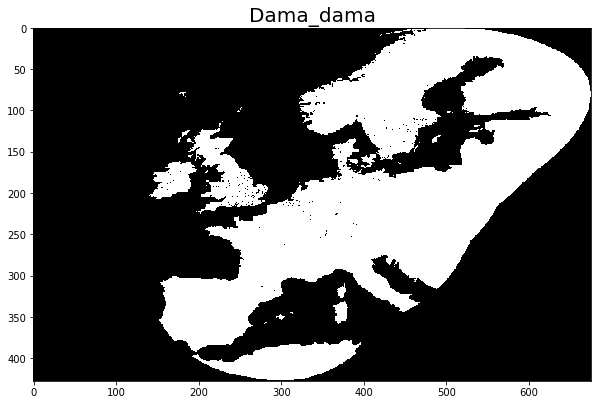

402 number of presences
1000 number of pseudo absences
1402 lenght data with pseudo absences pre-filtering
1363 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Damaliscus_korrigum')

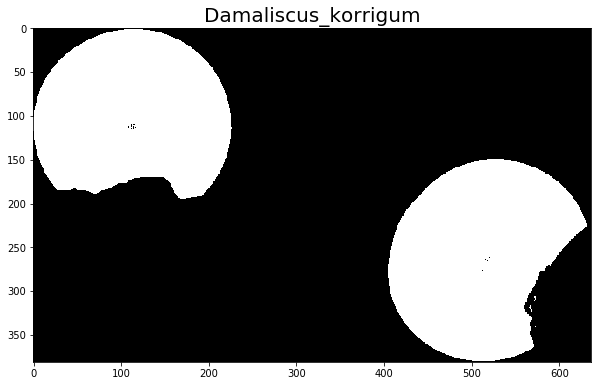

29 number of presences
1000 number of pseudo absences
1029 lenght data with pseudo absences pre-filtering
1016 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Damaliscus_lunatus')

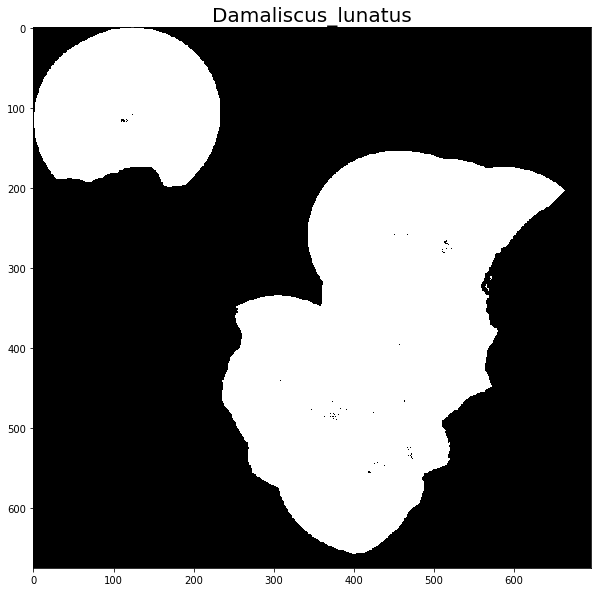

163 number of presences
1000 number of pseudo absences
1163 lenght data with pseudo absences pre-filtering
1155 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Damaliscus_pygargus')

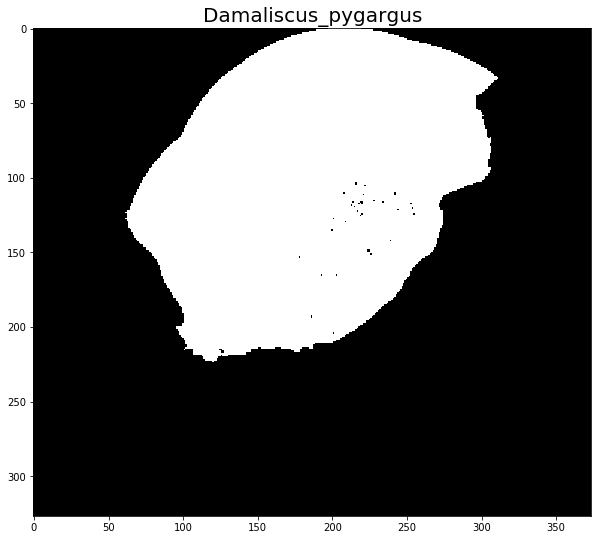

81 number of presences
1000 number of pseudo absences
1081 lenght data with pseudo absences pre-filtering
1073 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Diceros_bicornis')

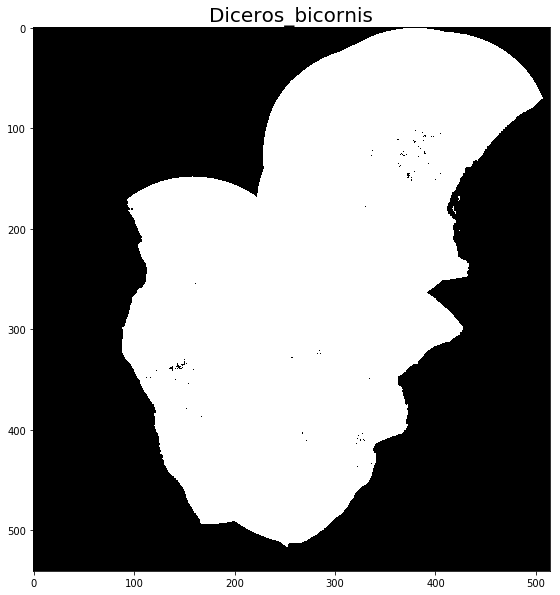

162 number of presences
1000 number of pseudo absences
1162 lenght data with pseudo absences pre-filtering
1150 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Equus_burchellii')

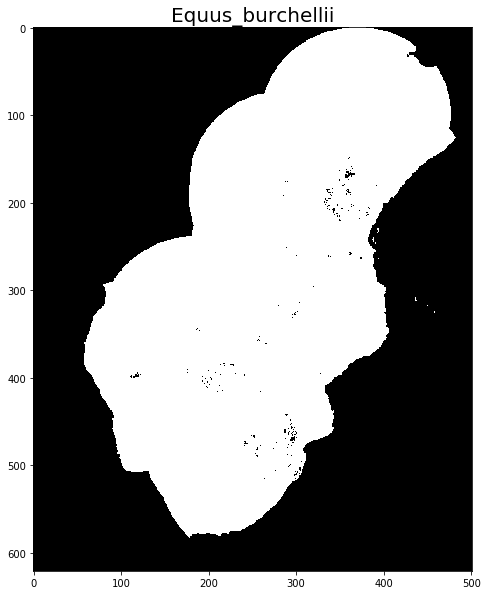

740 number of presences
1000 number of pseudo absences
1740 lenght data with pseudo absences pre-filtering
1728 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Equus_grevyi')

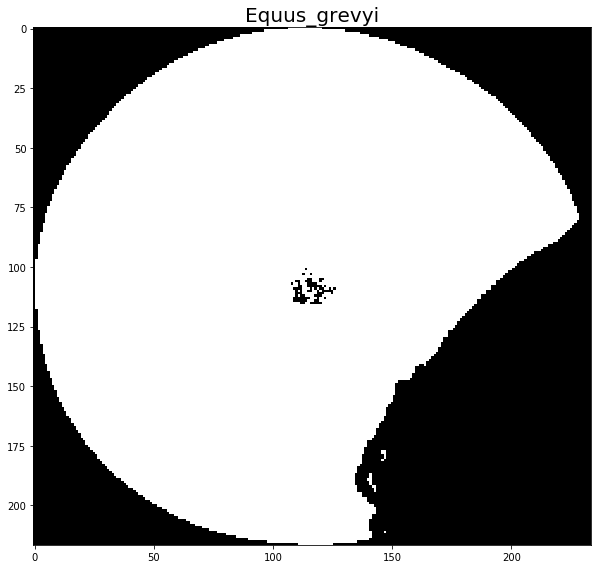

290 number of presences
1000 number of pseudo absences
1290 lenght data with pseudo absences pre-filtering
1258 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Equus_hemionus')

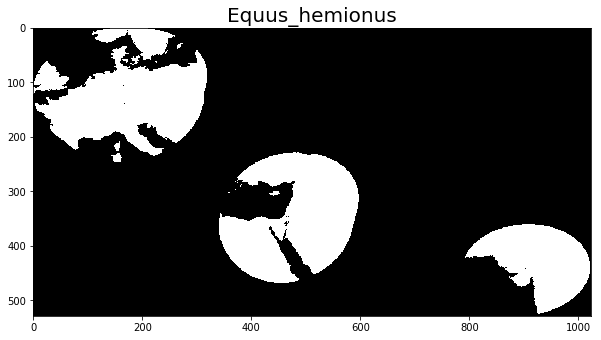

114 number of presences
1000 number of pseudo absences
1114 lenght data with pseudo absences pre-filtering
1114 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Equus_kiang')

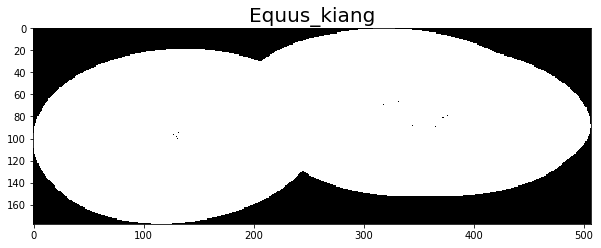

10 number of presences
1000 number of pseudo absences
1010 lenght data with pseudo absences pre-filtering
1008 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Equus_przewalskii')

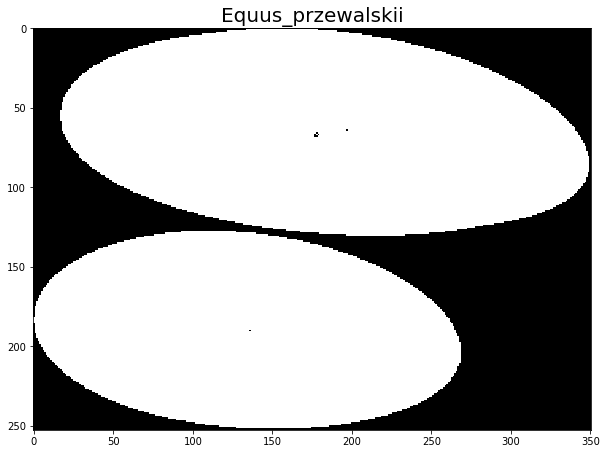

16 number of presences
1000 number of pseudo absences
1016 lenght data with pseudo absences pre-filtering
1009 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Equus_zebra')

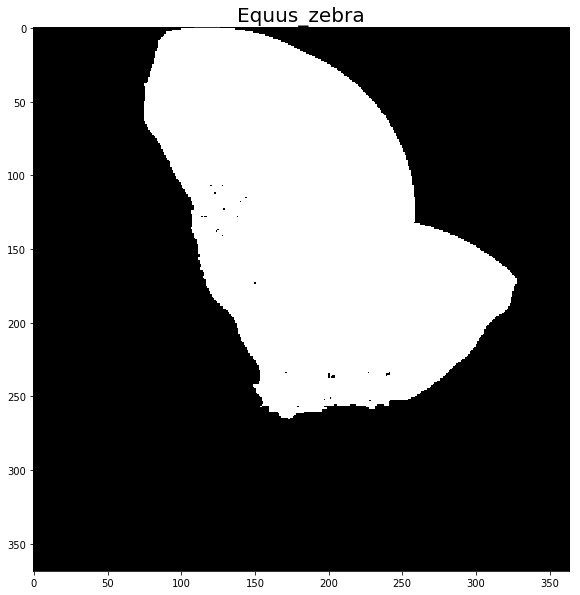

59 number of presences
1000 number of pseudo absences
1059 lenght data with pseudo absences pre-filtering
1048 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Eudorcas_rufifrons')

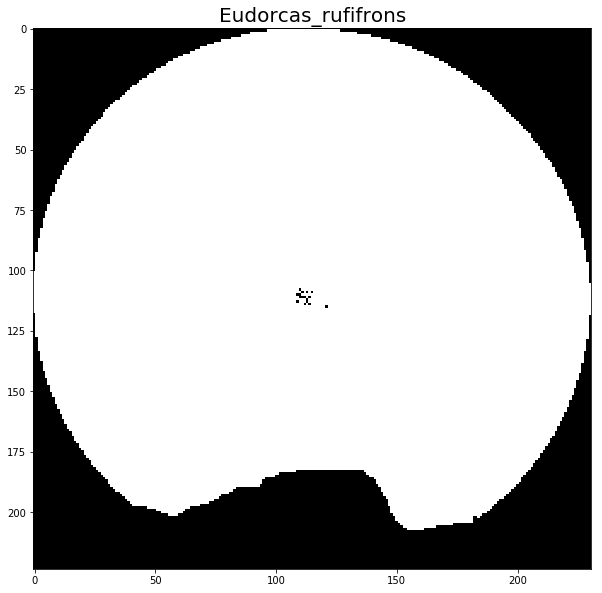

17 number of presences
1000 number of pseudo absences
1017 lenght data with pseudo absences pre-filtering
1017 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Eudorcas_thomsonii')

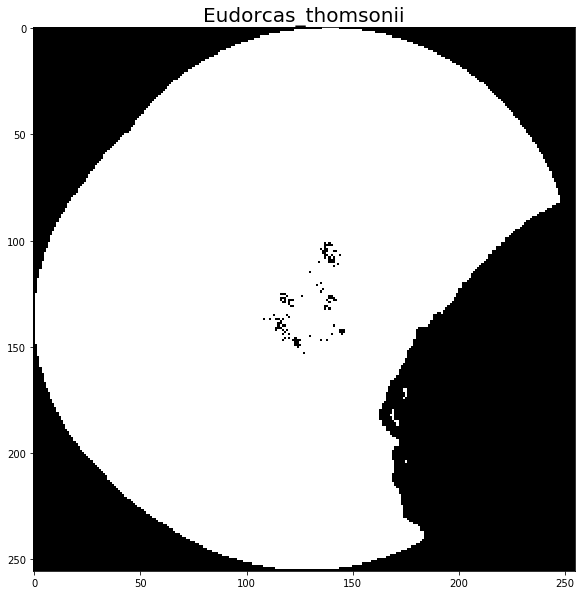

180 number of presences
1000 number of pseudo absences
1180 lenght data with pseudo absences pre-filtering
1161 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Gazella_bennettii')

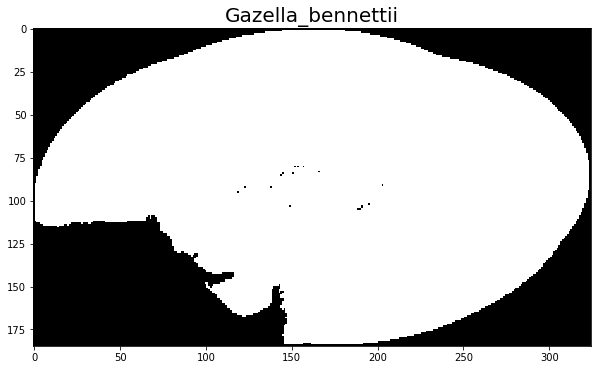

21 number of presences
1000 number of pseudo absences
1021 lenght data with pseudo absences pre-filtering
1021 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Gazella_dorcas')

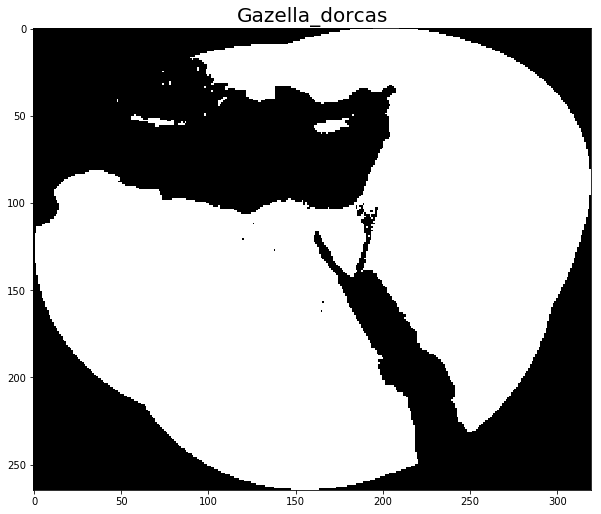

481 number of presences
1000 number of pseudo absences
1481 lenght data with pseudo absences pre-filtering
1476 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Gazella_gazella')

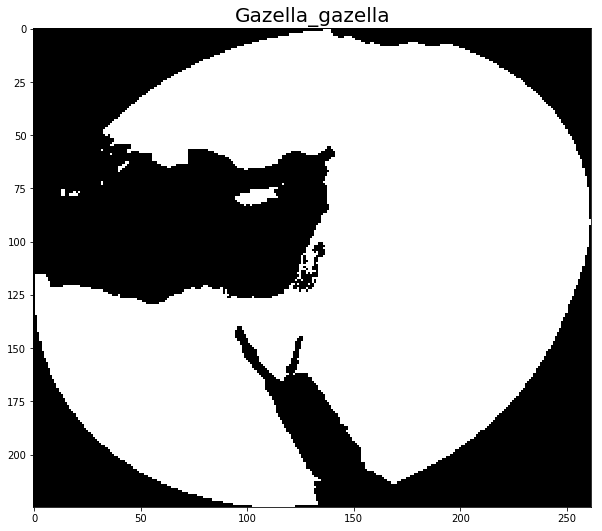

485 number of presences
1000 number of pseudo absences
1485 lenght data with pseudo absences pre-filtering
1473 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Gazella_subgutturosa')

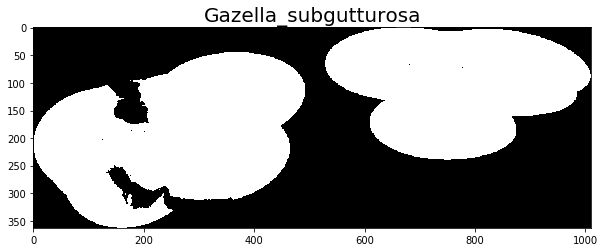

18 number of presences
1000 number of pseudo absences
1018 lenght data with pseudo absences pre-filtering
1010 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Giraffa_camelopardalis')

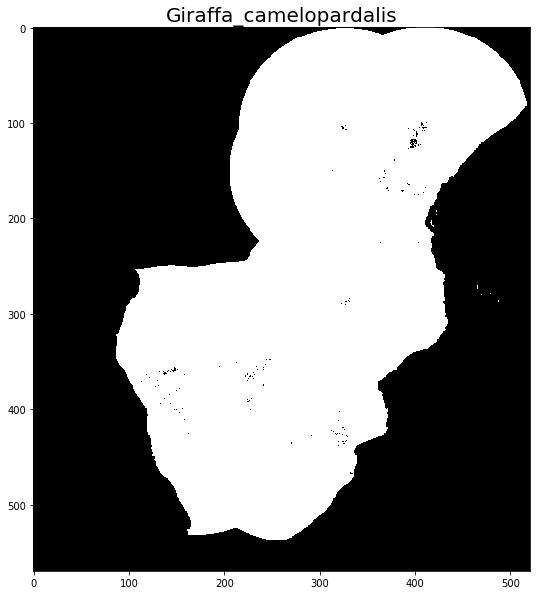

397 number of presences
1000 number of pseudo absences
1397 lenght data with pseudo absences pre-filtering
1389 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hemitragus_jemlahicus')

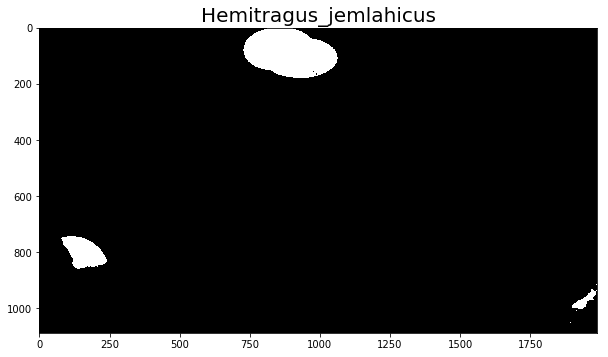

15 number of presences
1000 number of pseudo absences
1015 lenght data with pseudo absences pre-filtering
1013 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hippocamelus_antisensis')

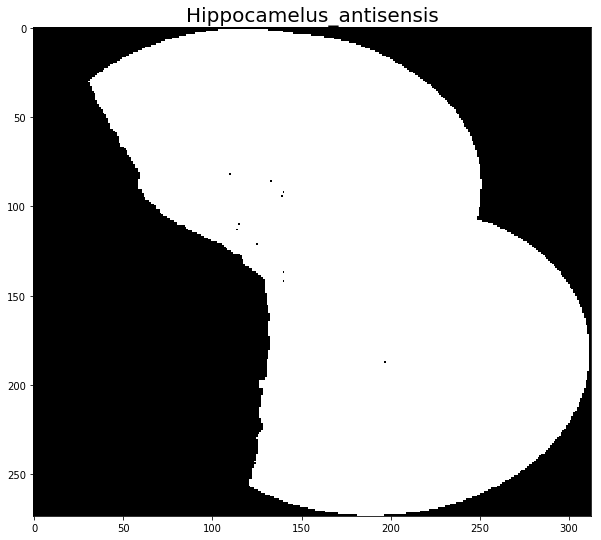

10 number of presences
1000 number of pseudo absences
1010 lenght data with pseudo absences pre-filtering
1009 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hippocamelus_bisulcus')

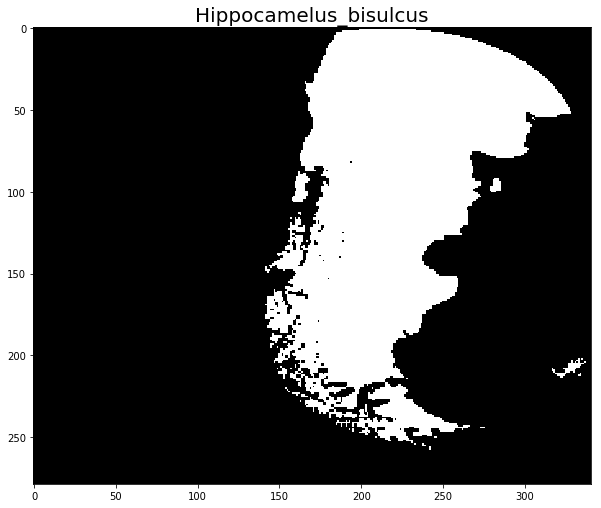

15 number of presences
1000 number of pseudo absences
1015 lenght data with pseudo absences pre-filtering
1015 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hippopotamus_amphibius')

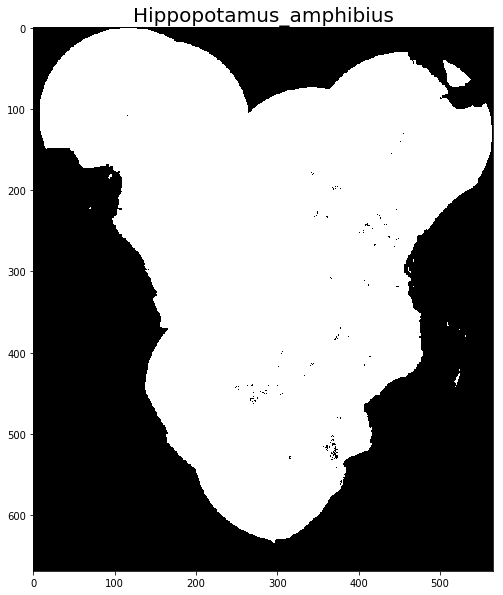

423 number of presences
1000 number of pseudo absences
1423 lenght data with pseudo absences pre-filtering
1399 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hippotragus_equinus')

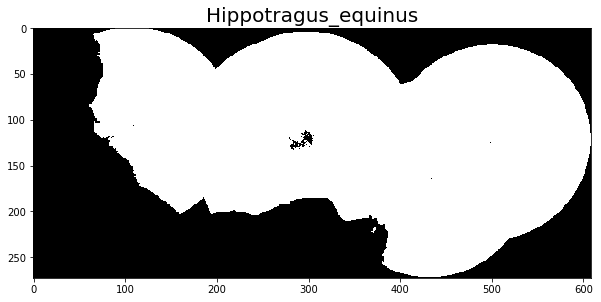

882 number of presences
1000 number of pseudo absences
1882 lenght data with pseudo absences pre-filtering
1882 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hippotragus_niger')

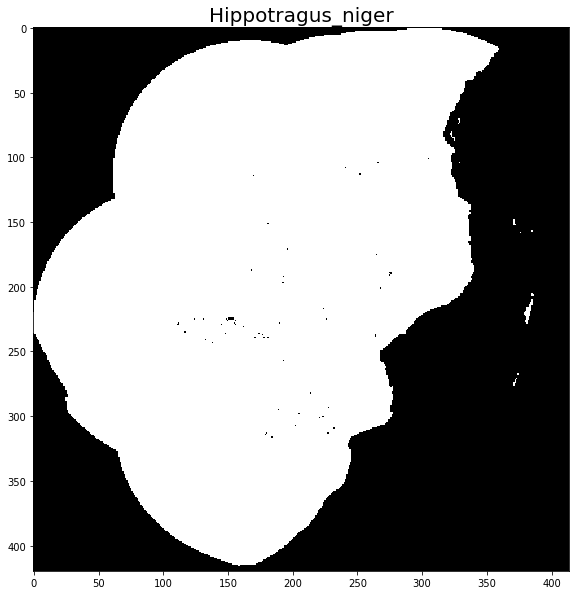

75 number of presences
1000 number of pseudo absences
1075 lenght data with pseudo absences pre-filtering
1061 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hyemoschus_aquaticus')

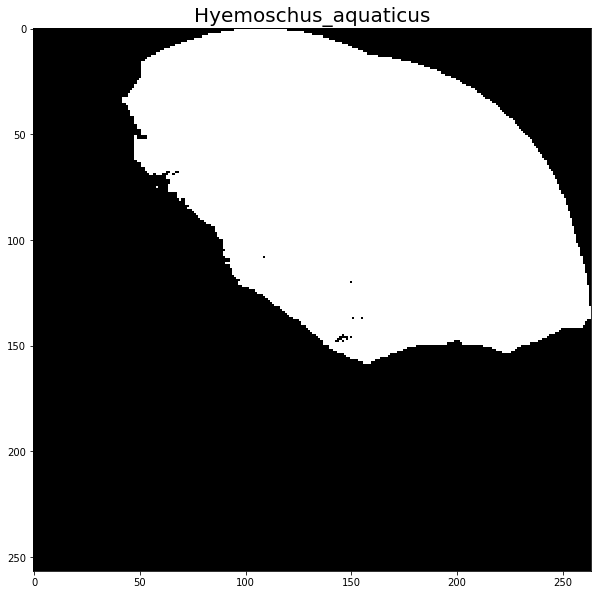

31 number of presences
1000 number of pseudo absences
1031 lenght data with pseudo absences pre-filtering
1030 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Hylochoerus_meinertzhageni')

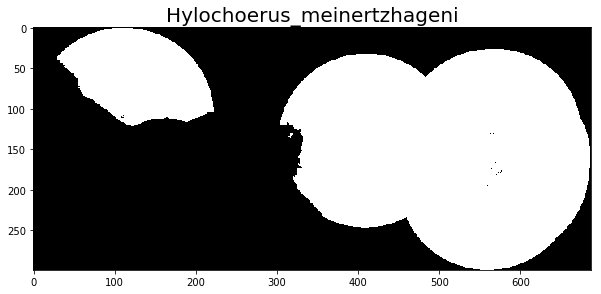

34 number of presences
1000 number of pseudo absences
1034 lenght data with pseudo absences pre-filtering
1029 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Kobus_ellipsiprymnus')

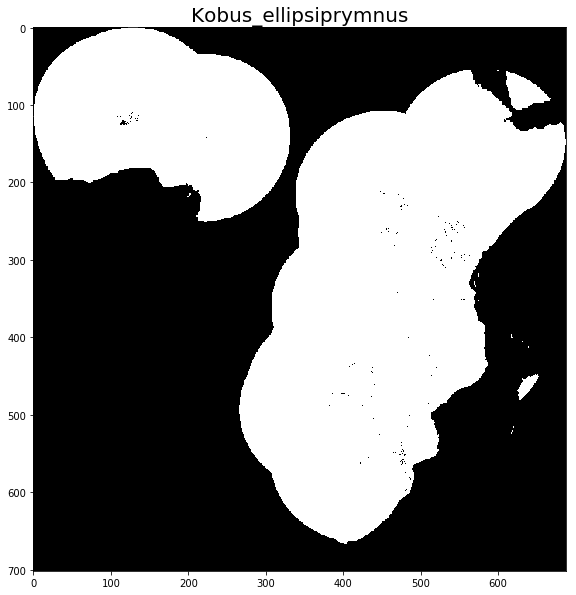

460 number of presences
1000 number of pseudo absences
1460 lenght data with pseudo absences pre-filtering
1445 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Kobus_kob')

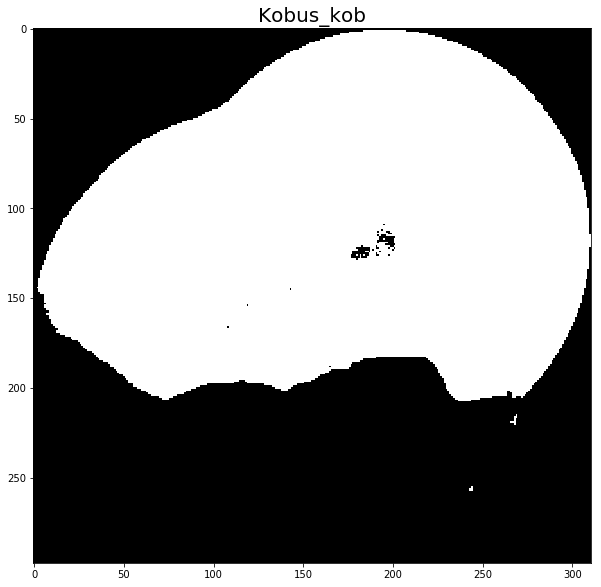

817 number of presences
1000 number of pseudo absences
1817 lenght data with pseudo absences pre-filtering
1817 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Kobus_leche')

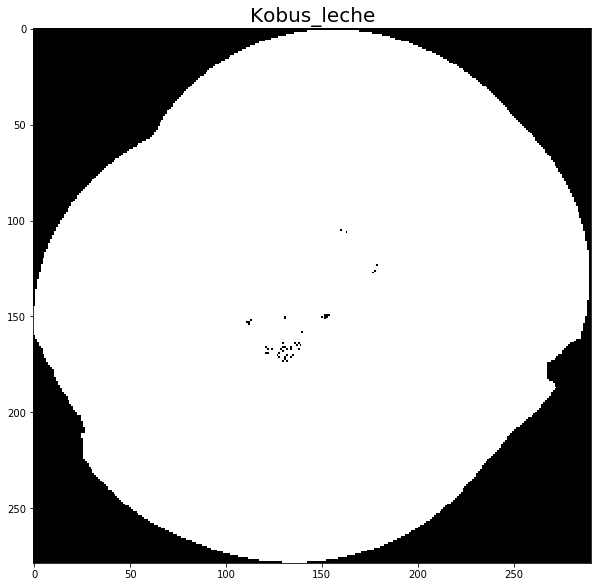

52 number of presences
1000 number of pseudo absences
1052 lenght data with pseudo absences pre-filtering
1046 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Kobus_megaceros')

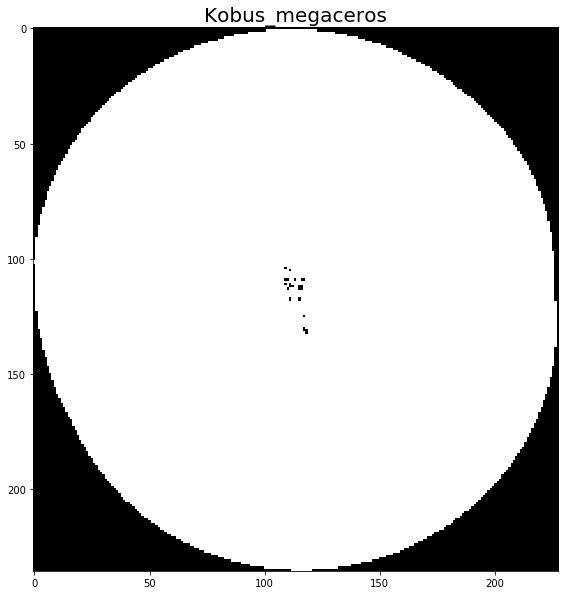

59 number of presences
1000 number of pseudo absences
1059 lenght data with pseudo absences pre-filtering
1051 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Kobus_vardonii')

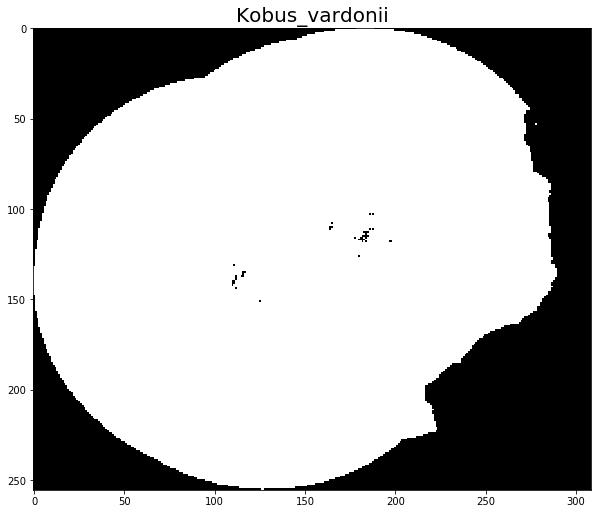

59 number of presences
1000 number of pseudo absences
1059 lenght data with pseudo absences pre-filtering
1051 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Lama_glama_guanicoe')

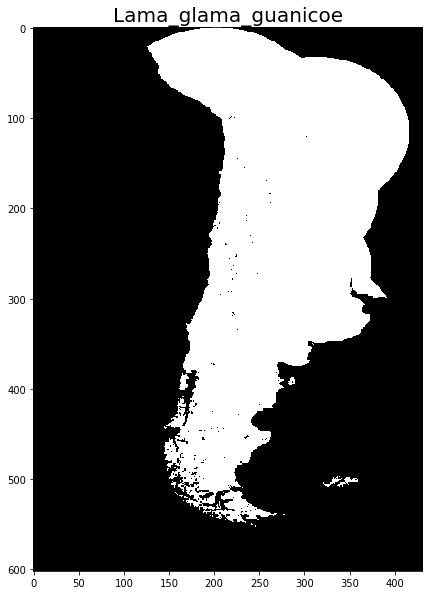

272 number of presences
1000 number of pseudo absences
1272 lenght data with pseudo absences pre-filtering
1262 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Litocranius_walleri')

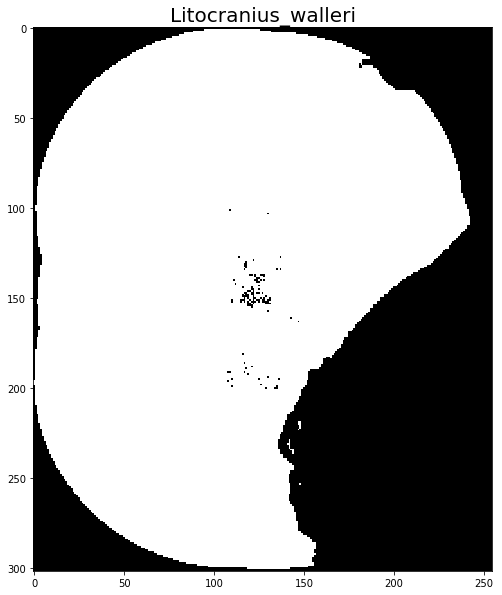

185 number of presences
1000 number of pseudo absences
1185 lenght data with pseudo absences pre-filtering
1156 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Madoqua_guentheri')

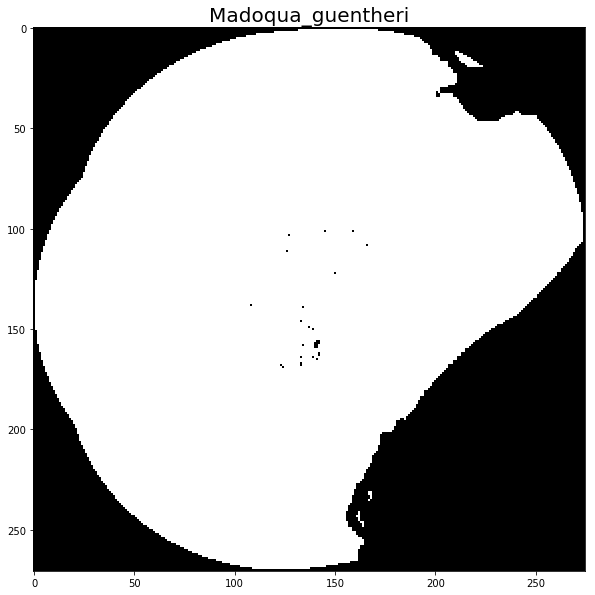

34 number of presences
1000 number of pseudo absences
1034 lenght data with pseudo absences pre-filtering
1019 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Madoqua_kirkii')

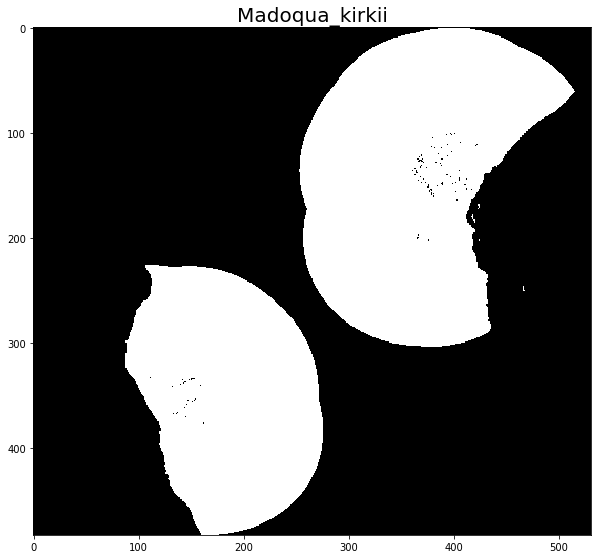

162 number of presences
1000 number of pseudo absences
1162 lenght data with pseudo absences pre-filtering
1144 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Madoqua_saltiana')

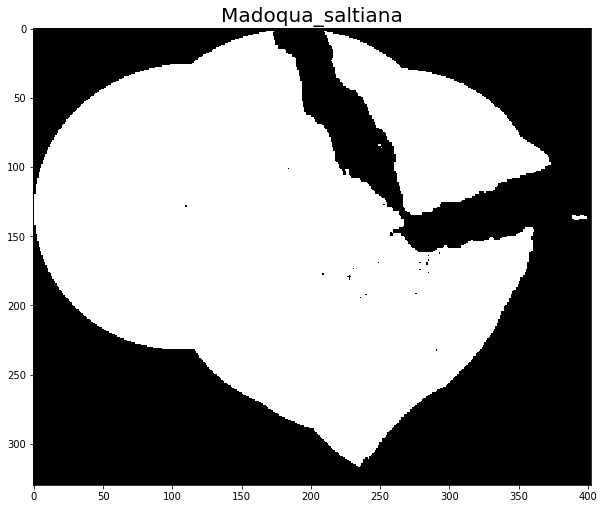

26 number of presences
1000 number of pseudo absences
1026 lenght data with pseudo absences pre-filtering
1024 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Mazama_americana')

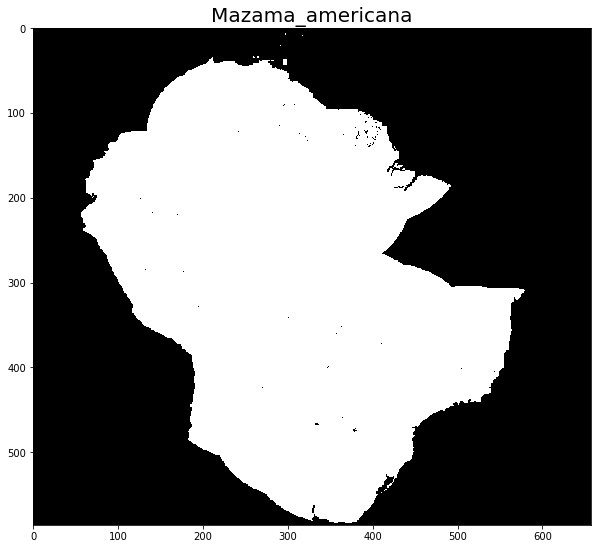

536 number of presences
1000 number of pseudo absences
1536 lenght data with pseudo absences pre-filtering
1533 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Mazama_gouazoubira')

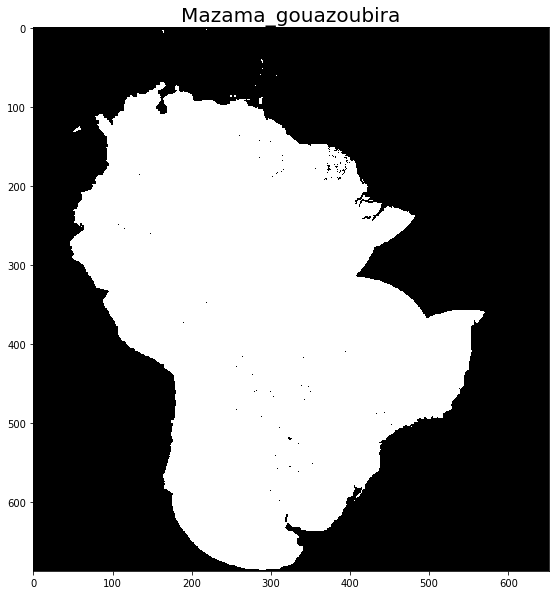

274 number of presences
1000 number of pseudo absences
1274 lenght data with pseudo absences pre-filtering
1269 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Mazama_nana')

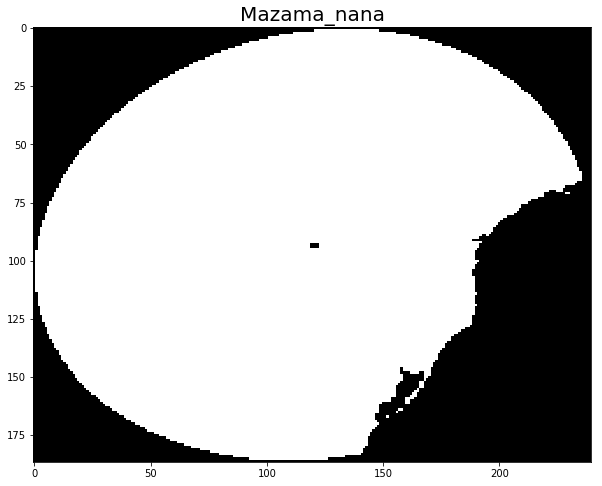

71 number of presences
1000 number of pseudo absences
1071 lenght data with pseudo absences pre-filtering
1071 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Mazama_pandora')

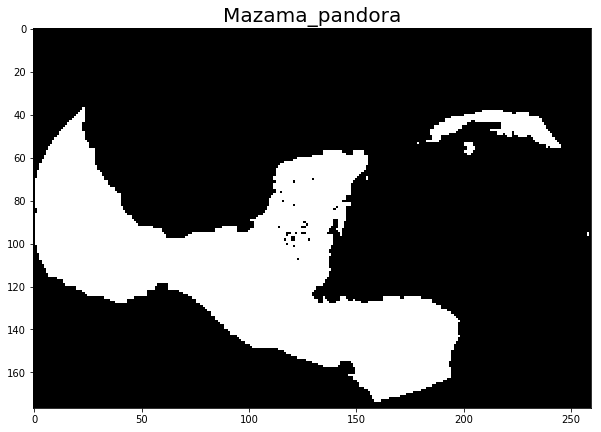

73 number of presences
1000 number of pseudo absences
1073 lenght data with pseudo absences pre-filtering
1071 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Mazama_rufina')

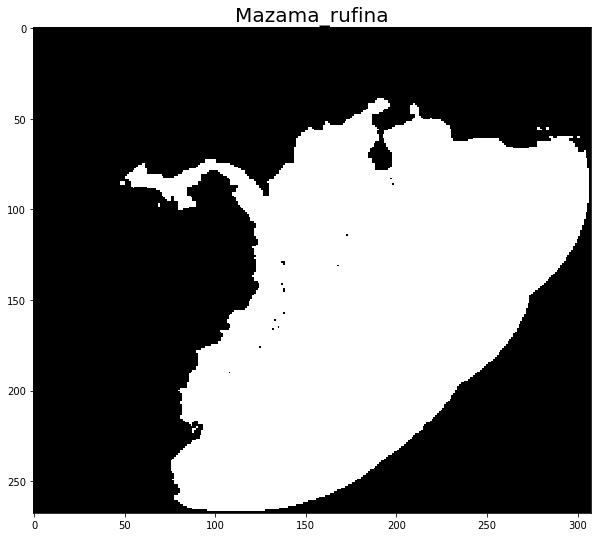

17 number of presences
1000 number of pseudo absences
1017 lenght data with pseudo absences pre-filtering
1017 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Mazama_temama')

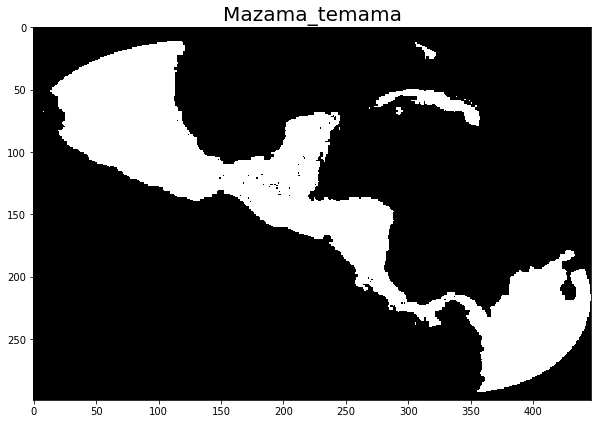

96 number of presences
1000 number of pseudo absences
1096 lenght data with pseudo absences pre-filtering
1092 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Muntiacus_muntjak')

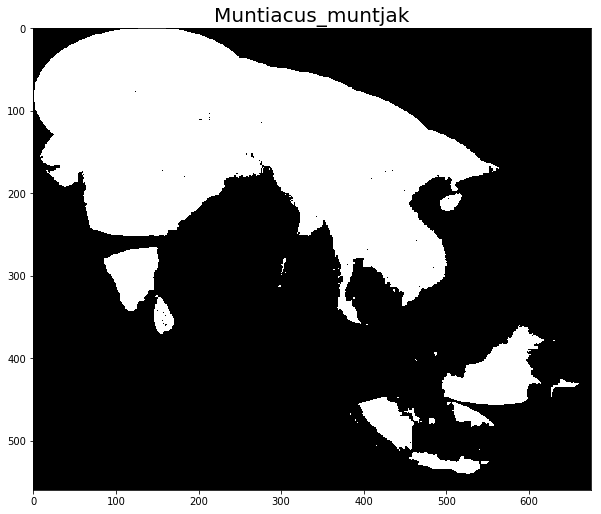

48 number of presences
1000 number of pseudo absences
1048 lenght data with pseudo absences pre-filtering
1047 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Muntiacus_reevesi')

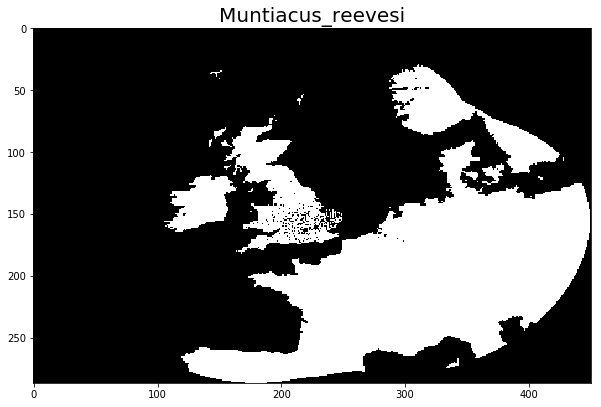

524 number of presences
1000 number of pseudo absences
1524 lenght data with pseudo absences pre-filtering
1471 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Nanger_granti')

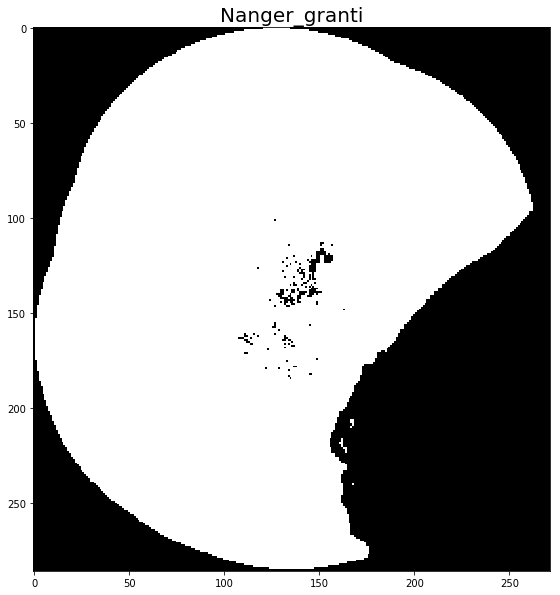

752 number of presences
1000 number of pseudo absences
1752 lenght data with pseudo absences pre-filtering
1732 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Nanger_soemmerringii')

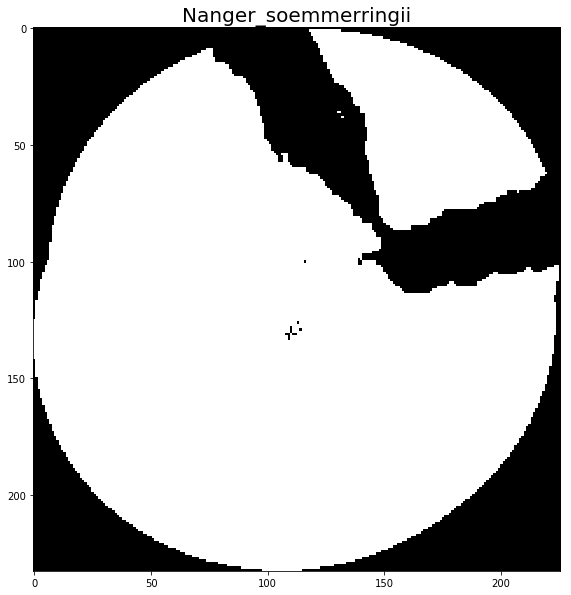

13 number of presences
1000 number of pseudo absences
1013 lenght data with pseudo absences pre-filtering
1010 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Neotragus_batesi')

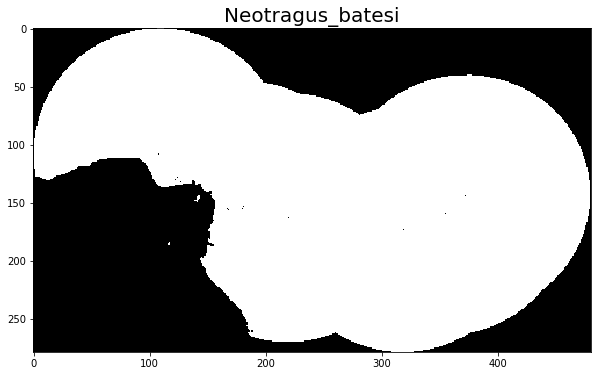

15 number of presences
1000 number of pseudo absences
1015 lenght data with pseudo absences pre-filtering
1003 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Neotragus_pygmaeus')

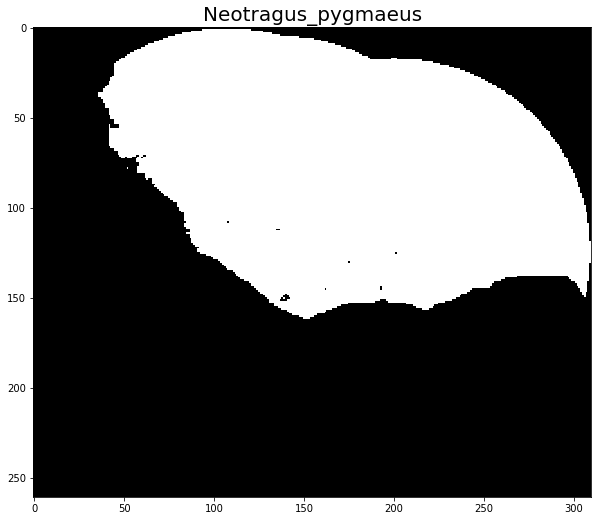

54 number of presences
1000 number of pseudo absences
1054 lenght data with pseudo absences pre-filtering
1053 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Odocoileus_hemionus')

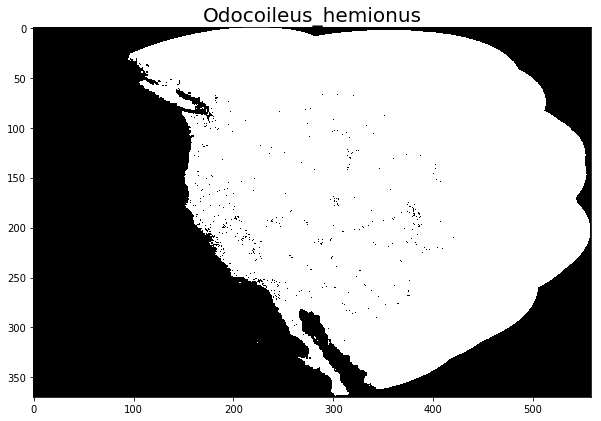

842 number of presences
1000 number of pseudo absences
1842 lenght data with pseudo absences pre-filtering
1738 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Odocoileus_virginianus')

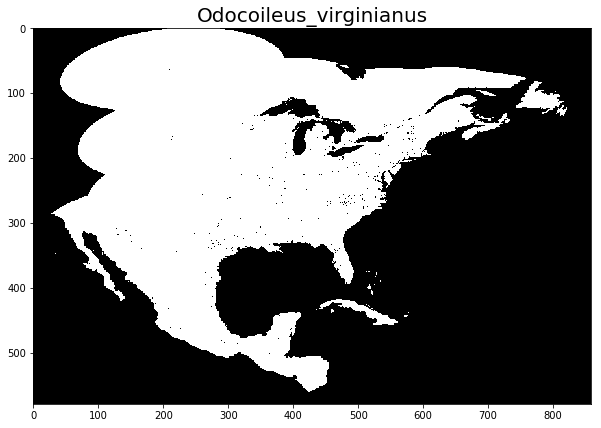

762 number of presences
1000 number of pseudo absences
1762 lenght data with pseudo absences pre-filtering
1713 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Oreamnos_americanus')

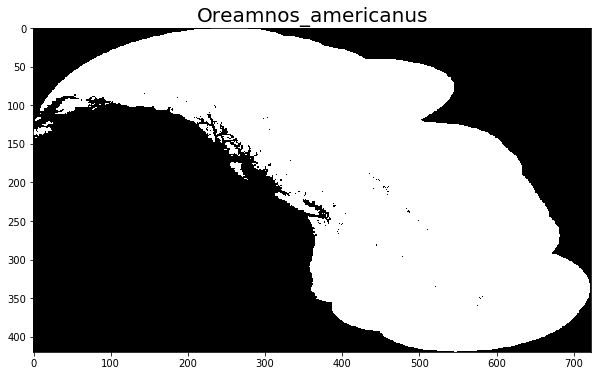

221 number of presences
1000 number of pseudo absences
1221 lenght data with pseudo absences pre-filtering
1208 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Oreotragus_oreotragus')

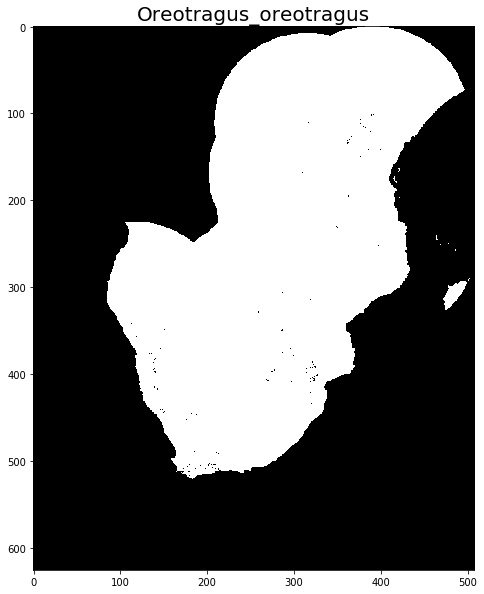

213 number of presences
1000 number of pseudo absences
1213 lenght data with pseudo absences pre-filtering
1199 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Oryx_beisa')

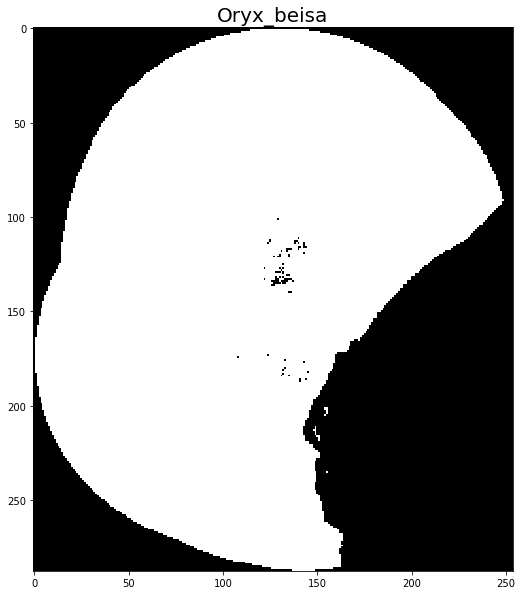

133 number of presences
1000 number of pseudo absences
1133 lenght data with pseudo absences pre-filtering
1107 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Oryx_gazella')

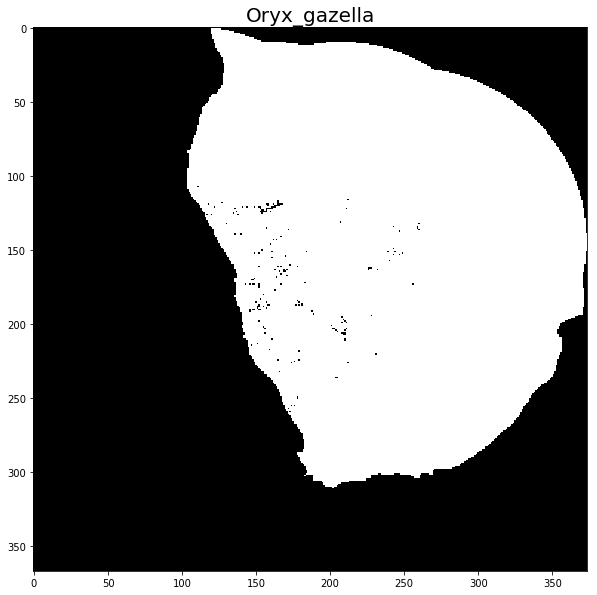

255 number of presences
1000 number of pseudo absences
1255 lenght data with pseudo absences pre-filtering
1254 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Oryx_leucoryx')

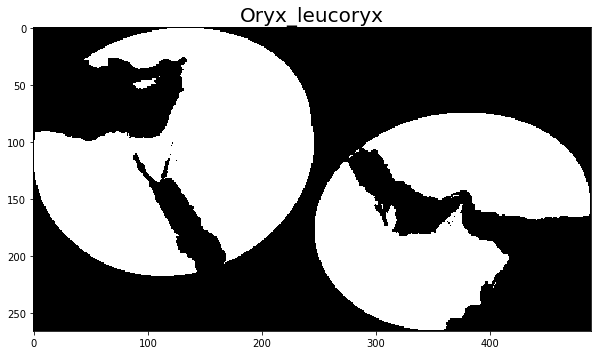

13 number of presences
1000 number of pseudo absences
1013 lenght data with pseudo absences pre-filtering
1013 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ourebia_ourebi')

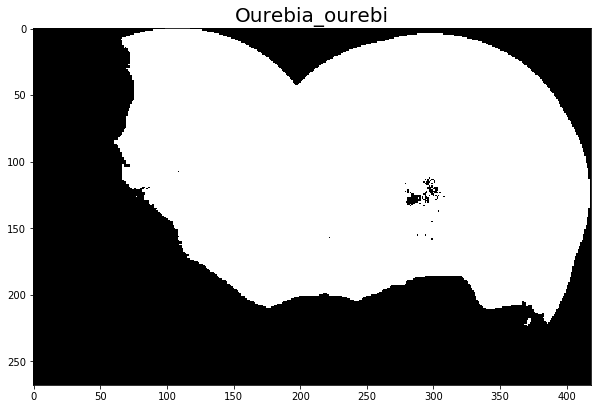

402 number of presences
1000 number of pseudo absences
1402 lenght data with pseudo absences pre-filtering
1402 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ovibos_moschatus')

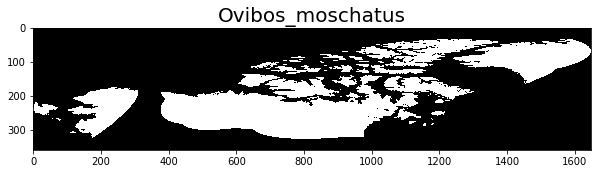

47 number of presences
1000 number of pseudo absences
1047 lenght data with pseudo absences pre-filtering
891 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ovis_ammon')

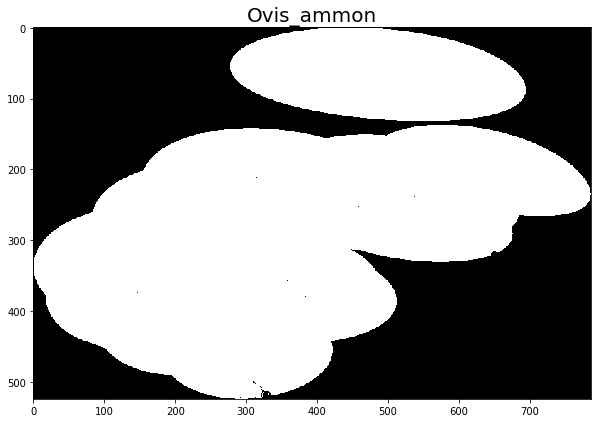

19 number of presences
1000 number of pseudo absences
1019 lenght data with pseudo absences pre-filtering
1016 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ovis_aries_orientalis')

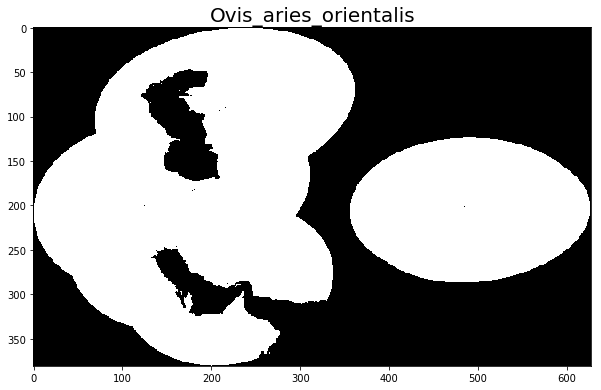

11 number of presences
1000 number of pseudo absences
1011 lenght data with pseudo absences pre-filtering
1006 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ovis_canadensis')

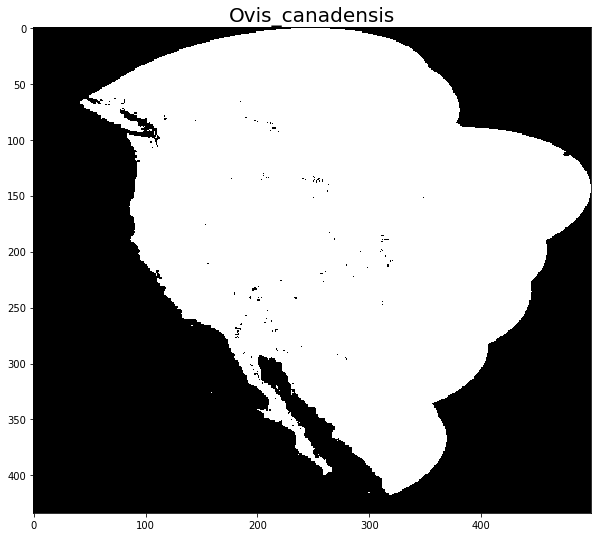

304 number of presences
1000 number of pseudo absences
1304 lenght data with pseudo absences pre-filtering
1293 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ovis_dalli')

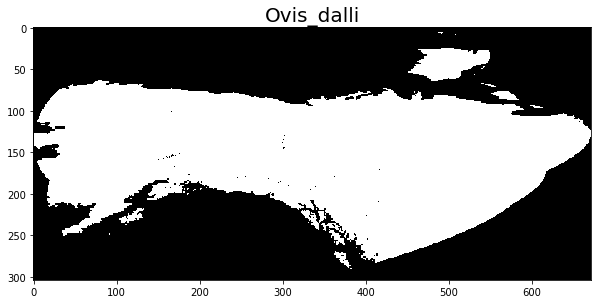

71 number of presences
1000 number of pseudo absences
1071 lenght data with pseudo absences pre-filtering
1053 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Ozotoceros_bezoarticus')

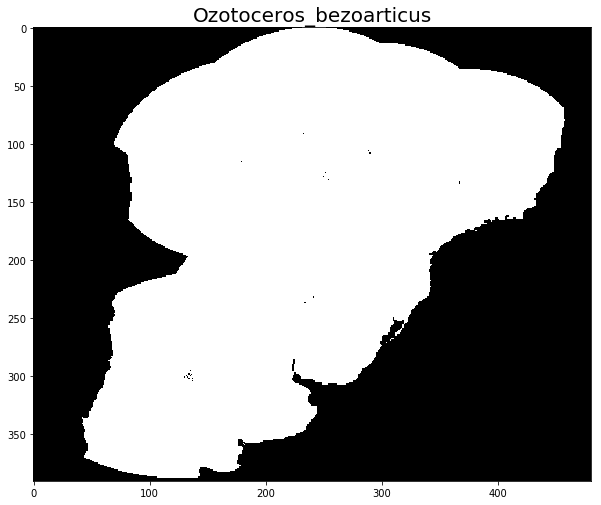

24 number of presences
1000 number of pseudo absences
1024 lenght data with pseudo absences pre-filtering
1023 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Pecari_tajacu')

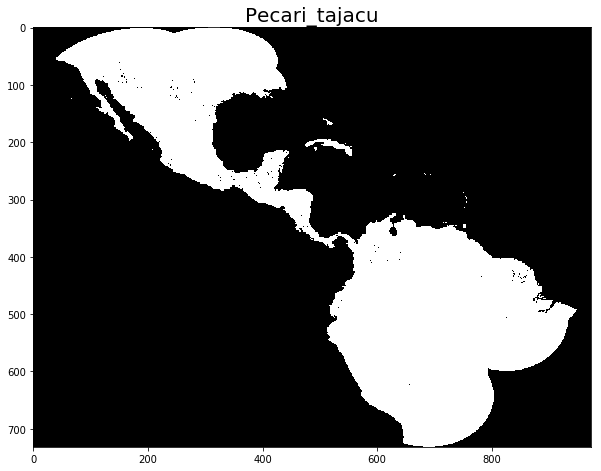

537 number of presences
1000 number of pseudo absences
1537 lenght data with pseudo absences pre-filtering
1519 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Pelea_capreolus')

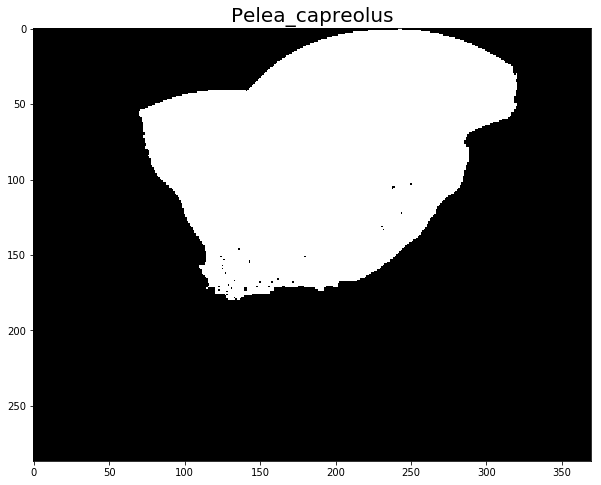

39 number of presences
1000 number of pseudo absences
1039 lenght data with pseudo absences pre-filtering
1039 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Phacochoerus_aethiopicus')

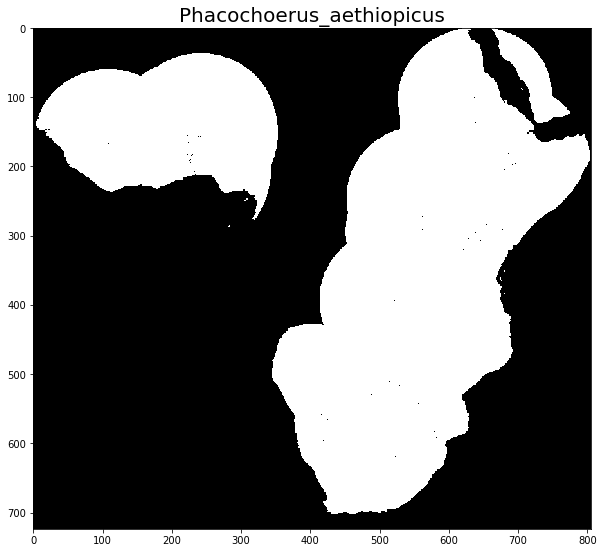

85 number of presences
1000 number of pseudo absences
1085 lenght data with pseudo absences pre-filtering
1081 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Phacochoerus_africanus')

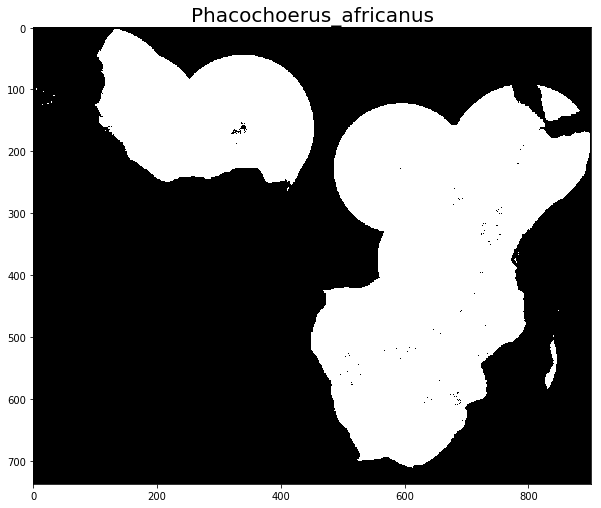

639 number of presences
1000 number of pseudo absences
1639 lenght data with pseudo absences pre-filtering
1628 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Philantomba_maxwellii')

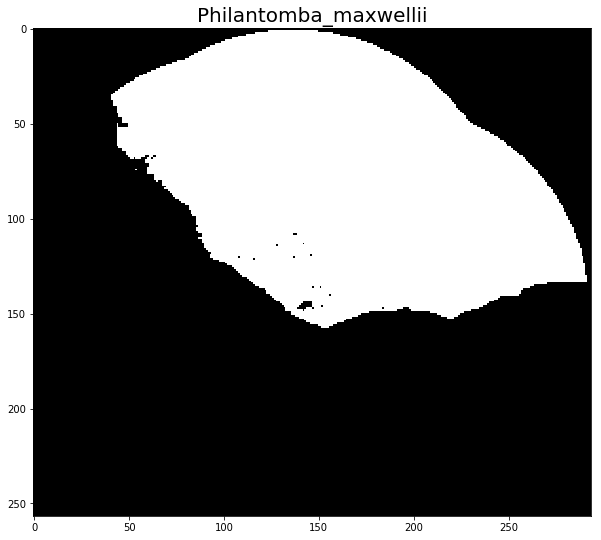

247 number of presences
1000 number of pseudo absences
1247 lenght data with pseudo absences pre-filtering
1247 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Philantomba_monticola')

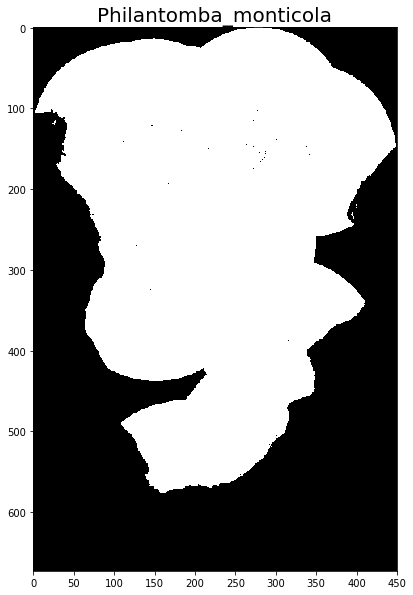

94 number of presences
1000 number of pseudo absences
1094 lenght data with pseudo absences pre-filtering
1062 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Potamochoerus_larvatus')

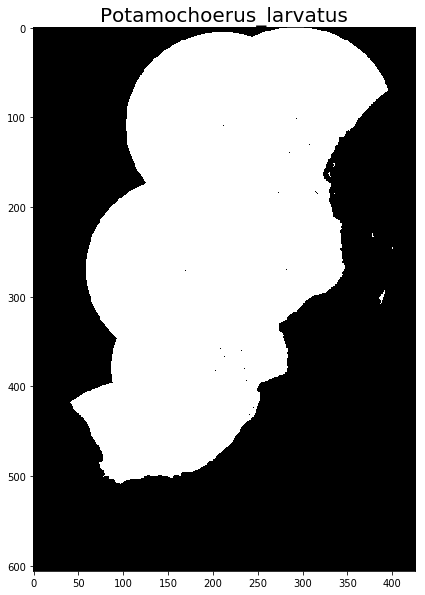

41 number of presences
1000 number of pseudo absences
1041 lenght data with pseudo absences pre-filtering
1023 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Potamochoerus_porcus')

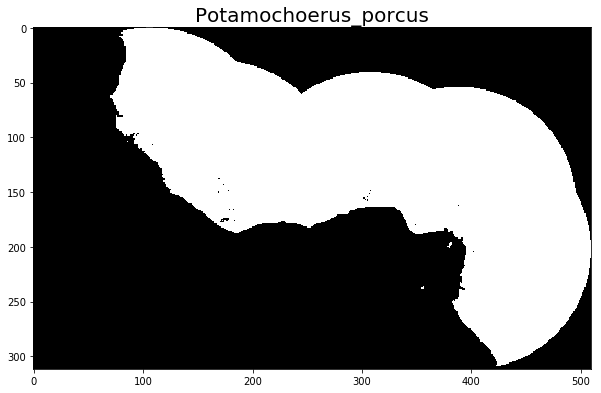

106 number of presences
1000 number of pseudo absences
1106 lenght data with pseudo absences pre-filtering
1106 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Procapra_picticaudata')

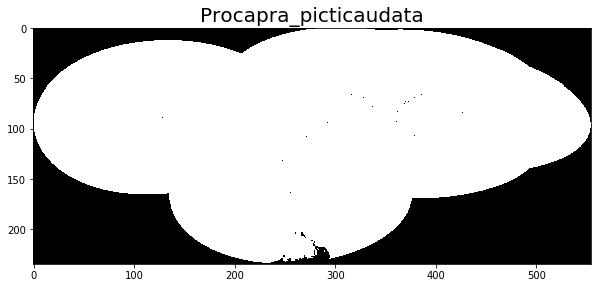

17 number of presences
1000 number of pseudo absences
1017 lenght data with pseudo absences pre-filtering
1016 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Pseudois_nayaur')

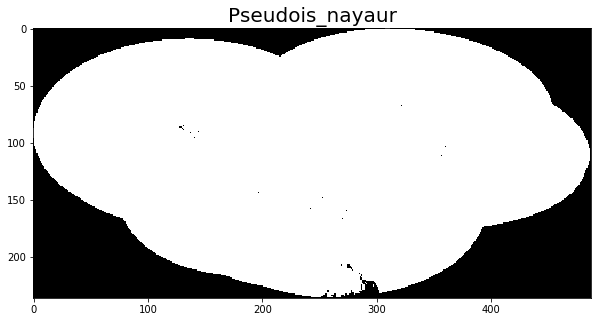

17 number of presences
1000 number of pseudo absences
1017 lenght data with pseudo absences pre-filtering
1016 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Pudu_puda')

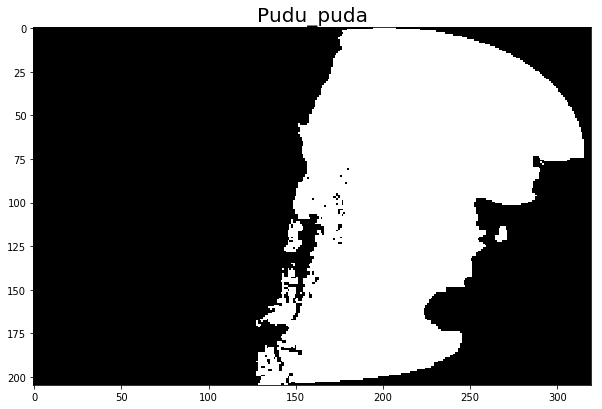

94 number of presences
1000 number of pseudo absences
1094 lenght data with pseudo absences pre-filtering
1094 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Rangifer_tarandus')

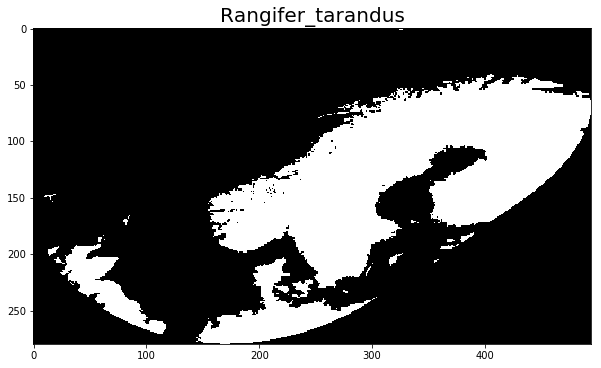

44 number of presences
1000 number of pseudo absences
1044 lenght data with pseudo absences pre-filtering
1042 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Raphicerus_campestris')

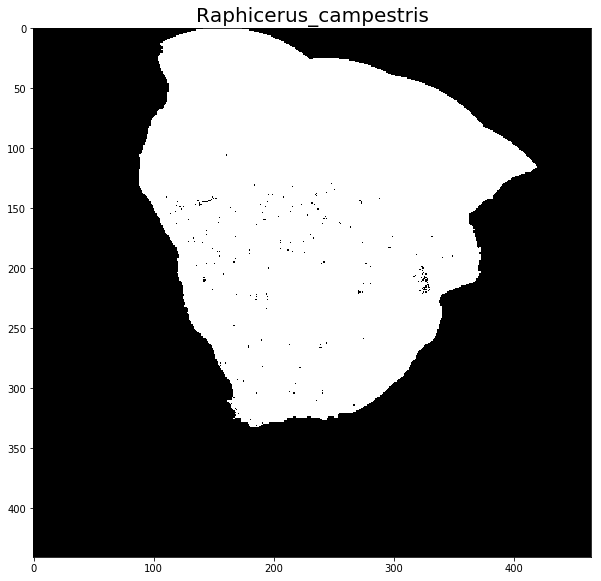

289 number of presences
1000 number of pseudo absences
1289 lenght data with pseudo absences pre-filtering
1283 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Raphicerus_melanotis')

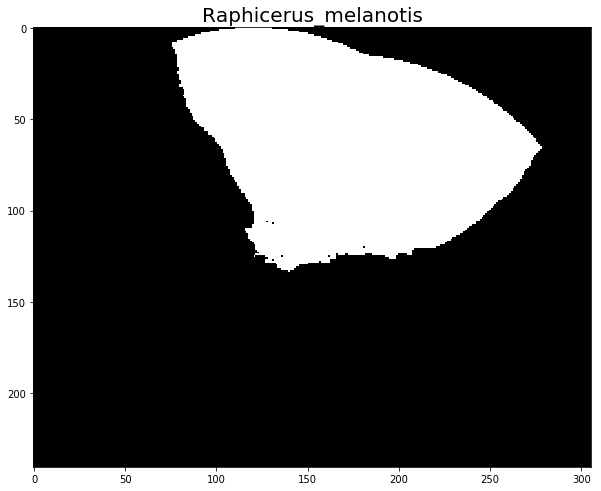

29 number of presences
1000 number of pseudo absences
1029 lenght data with pseudo absences pre-filtering
1020 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Raphicerus_sharpei')

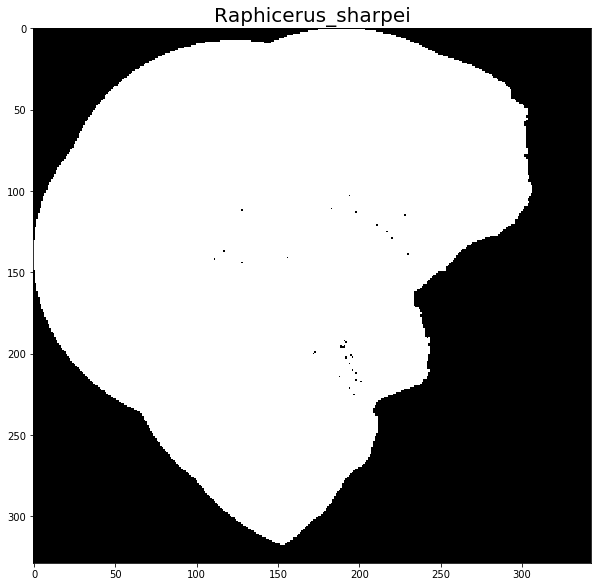

40 number of presences
1000 number of pseudo absences
1040 lenght data with pseudo absences pre-filtering
1035 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Redunca_arundinum')

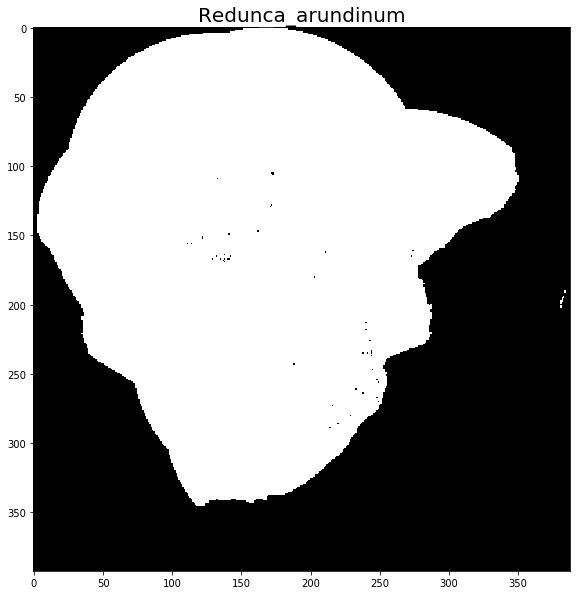

70 number of presences
1000 number of pseudo absences
1070 lenght data with pseudo absences pre-filtering
1056 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Redunca_fulvorufula')

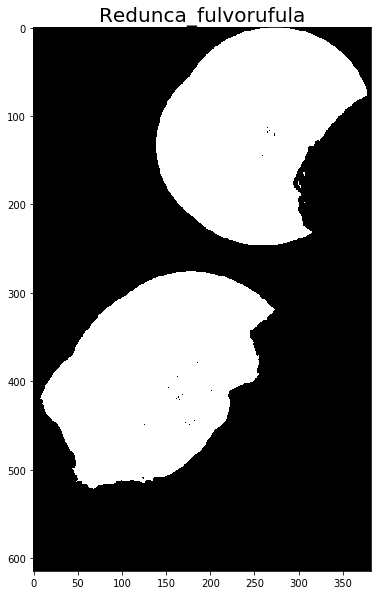

33 number of presences
1000 number of pseudo absences
1033 lenght data with pseudo absences pre-filtering
1019 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Redunca_redunca')

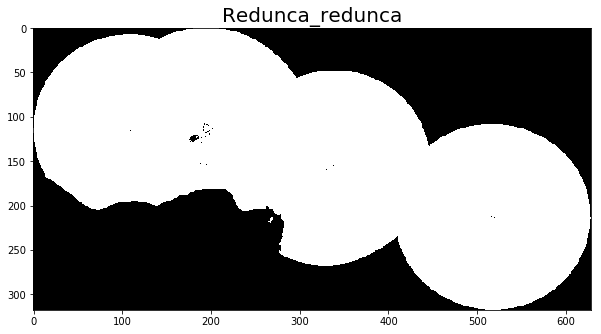

514 number of presences
1000 number of pseudo absences
1514 lenght data with pseudo absences pre-filtering
1509 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Rhinoceros_unicornis')

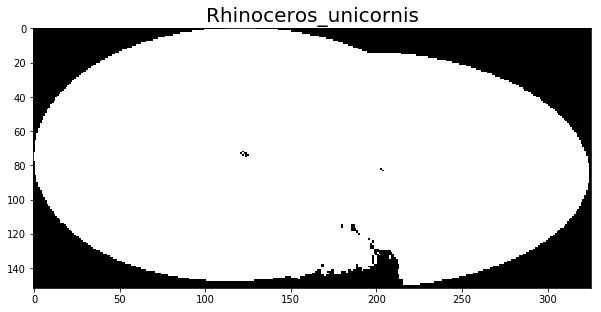

14 number of presences
1000 number of pseudo absences
1014 lenght data with pseudo absences pre-filtering
1013 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Rucervus_duvaucelii')

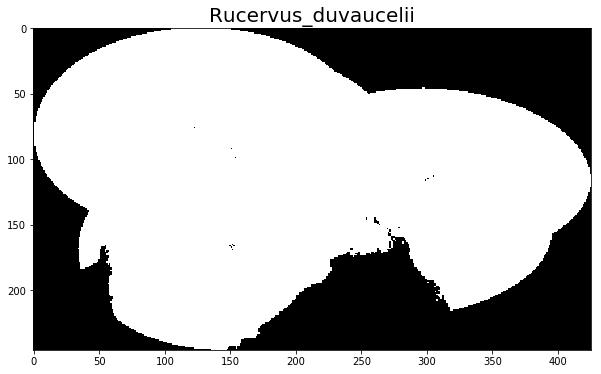

14 number of presences
1000 number of pseudo absences
1014 lenght data with pseudo absences pre-filtering
1014 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Rupicapra_pyrenaica')

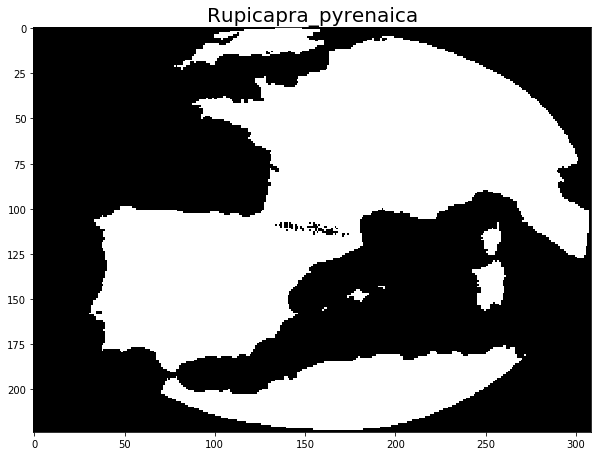

203 number of presences
1000 number of pseudo absences
1203 lenght data with pseudo absences pre-filtering
1203 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Rupicapra_rupicapra')

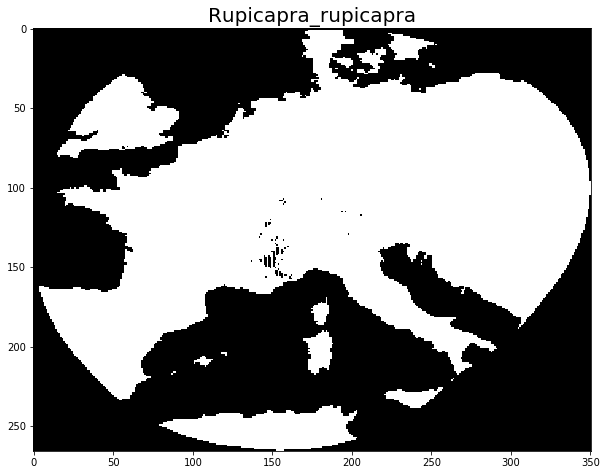

110 number of presences
1000 number of pseudo absences
1110 lenght data with pseudo absences pre-filtering
1110 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Rusa_timorensis')

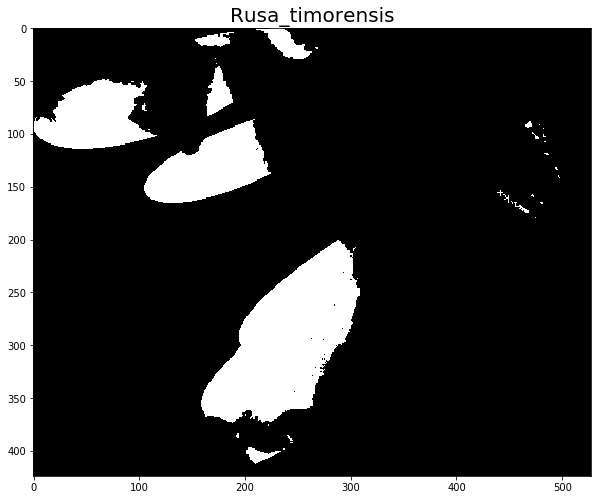

545 number of presences
1000 number of pseudo absences
1545 lenght data with pseudo absences pre-filtering
1294 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Rusa_unicolor')

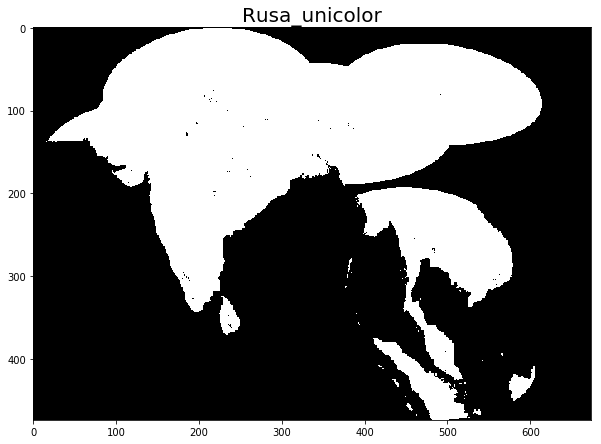

95 number of presences
1000 number of pseudo absences
1095 lenght data with pseudo absences pre-filtering
1095 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Sus_barbatus')

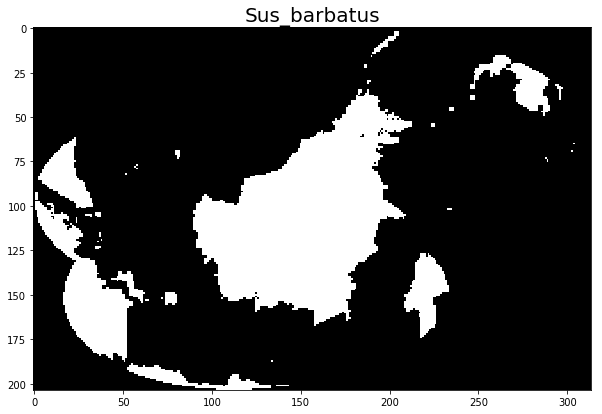

21 number of presences
1000 number of pseudo absences
1021 lenght data with pseudo absences pre-filtering
1017 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Sus_cebifrons')

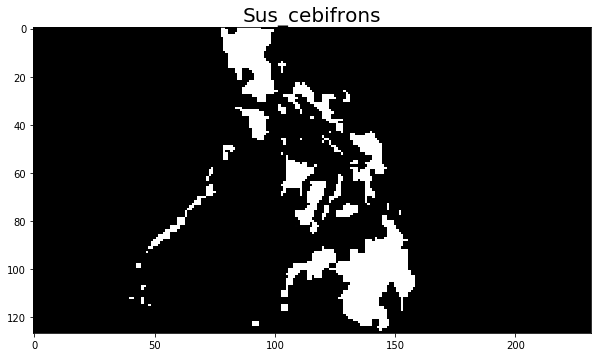

14 number of presences
1000 number of pseudo absences
1014 lenght data with pseudo absences pre-filtering
1010 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Sus_philippensis')

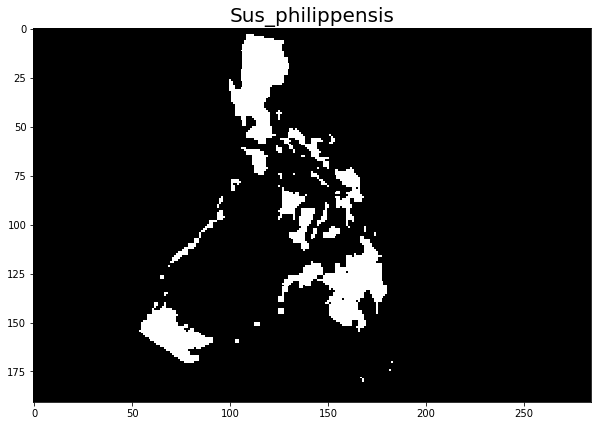

17 number of presences
1000 number of pseudo absences
1017 lenght data with pseudo absences pre-filtering
1008 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Sus_scrofa')

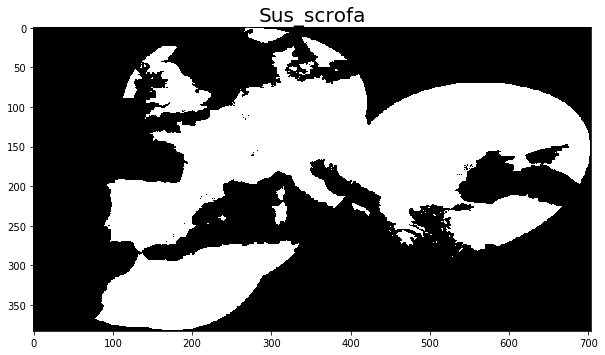

88 number of presences
1000 number of pseudo absences
1088 lenght data with pseudo absences pre-filtering
1083 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Sylvicapra_grimmia')

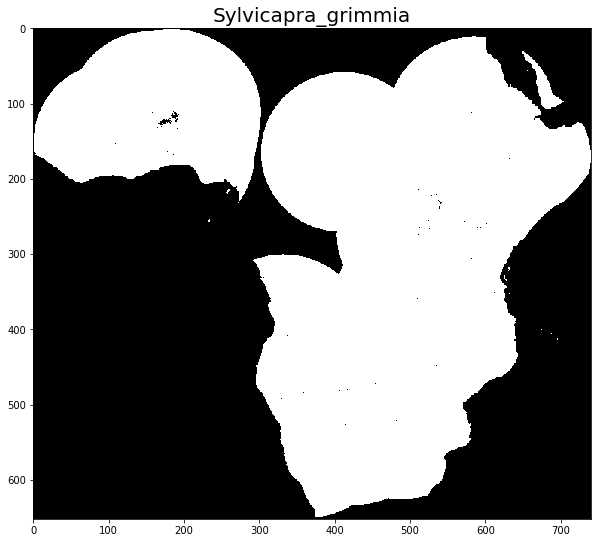

530 number of presences
1000 number of pseudo absences
1530 lenght data with pseudo absences pre-filtering
1528 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Syncerus_caffer')

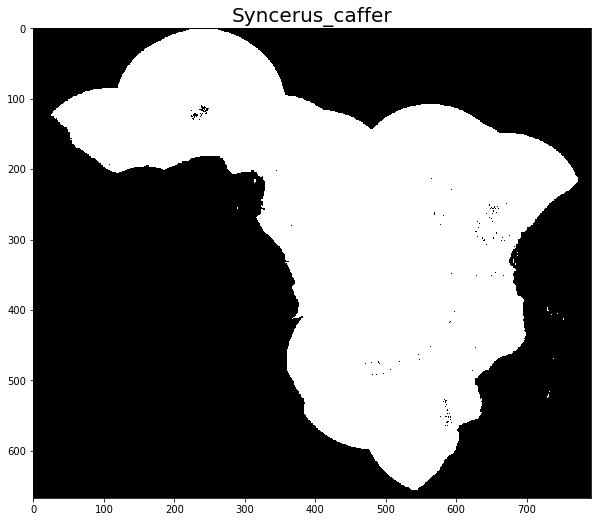

599 number of presences
1000 number of pseudo absences
1599 lenght data with pseudo absences pre-filtering
1592 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tapirus_bairdii')

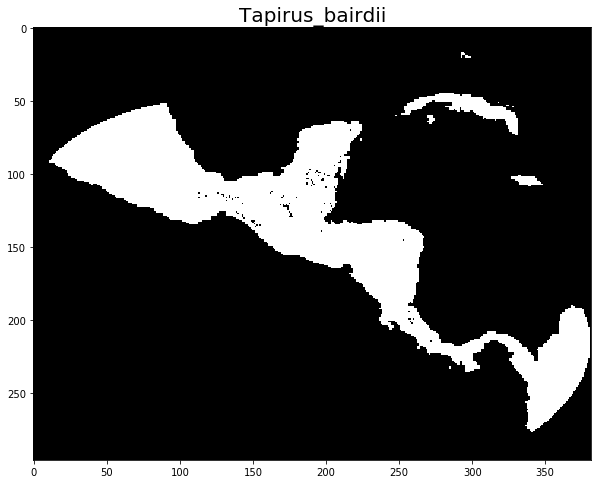

201 number of presences
1000 number of pseudo absences
1201 lenght data with pseudo absences pre-filtering
1189 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tapirus_pinchaque')

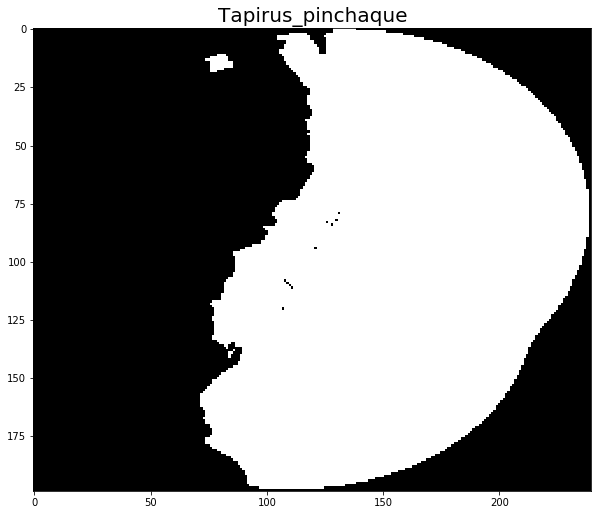

10 number of presences
1000 number of pseudo absences
1010 lenght data with pseudo absences pre-filtering
1010 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tapirus_terrestris')

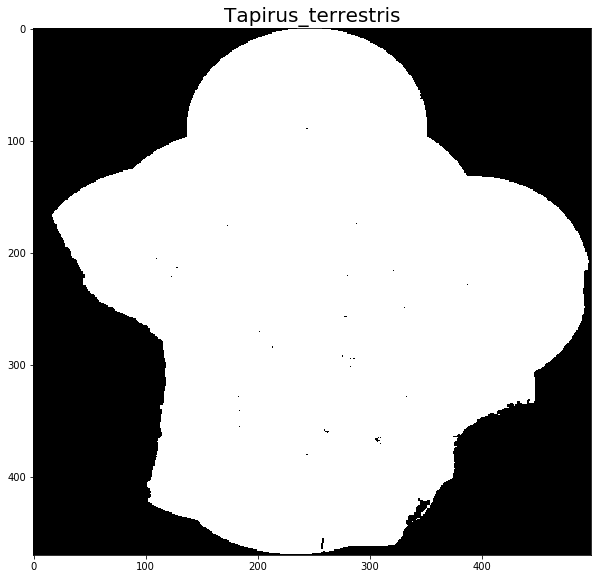

677 number of presences
1000 number of pseudo absences
1677 lenght data with pseudo absences pre-filtering
1677 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Taurotragus_oryx')

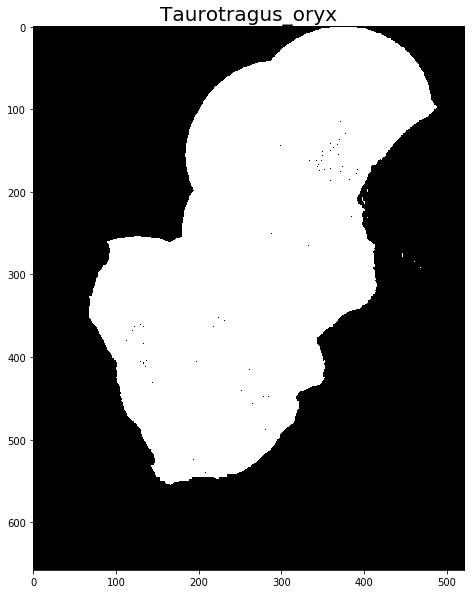

101 number of presences
1000 number of pseudo absences
1101 lenght data with pseudo absences pre-filtering
1080 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tayassu_pecari')

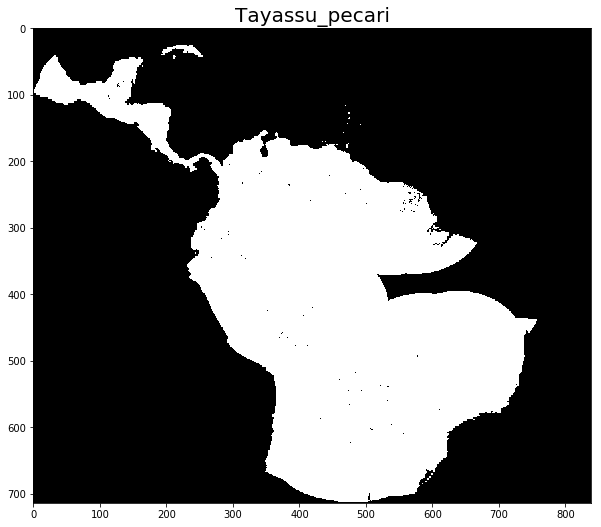

316 number of presences
1000 number of pseudo absences
1316 lenght data with pseudo absences pre-filtering
1312 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragelaphus_angasii')

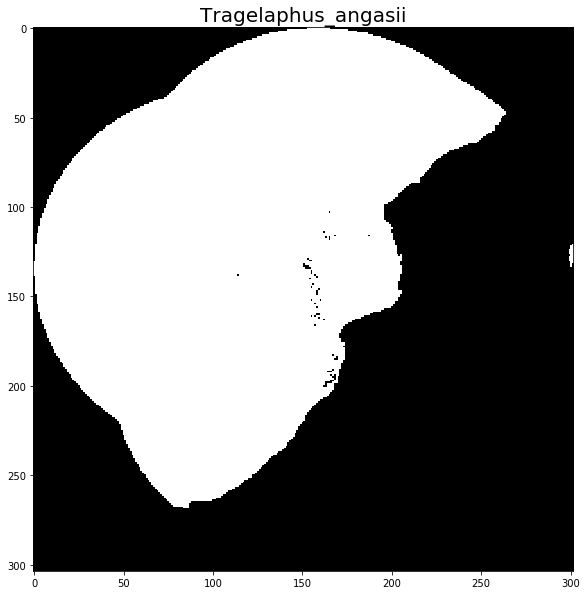

181 number of presences
1000 number of pseudo absences
1181 lenght data with pseudo absences pre-filtering
1176 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragelaphus_buxtoni')

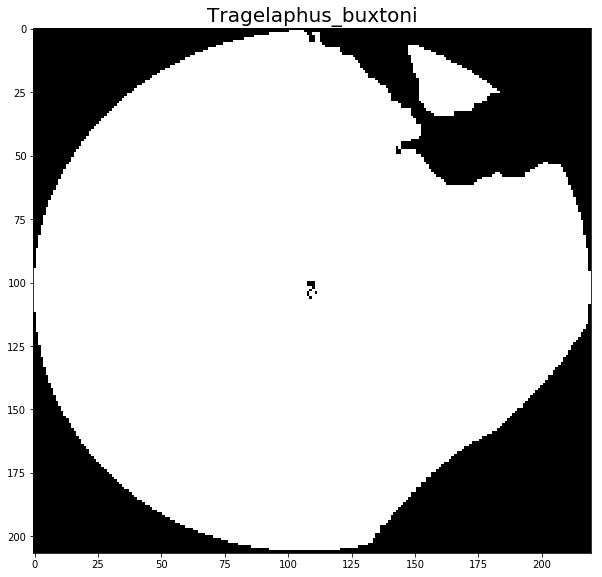

15 number of presences
1000 number of pseudo absences
1015 lenght data with pseudo absences pre-filtering
1013 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragelaphus_eurycerus')

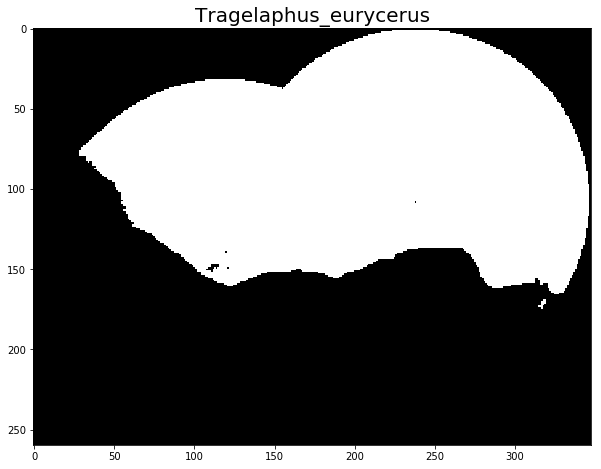

55 number of presences
1000 number of pseudo absences
1055 lenght data with pseudo absences pre-filtering
1054 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragelaphus_imberbis')

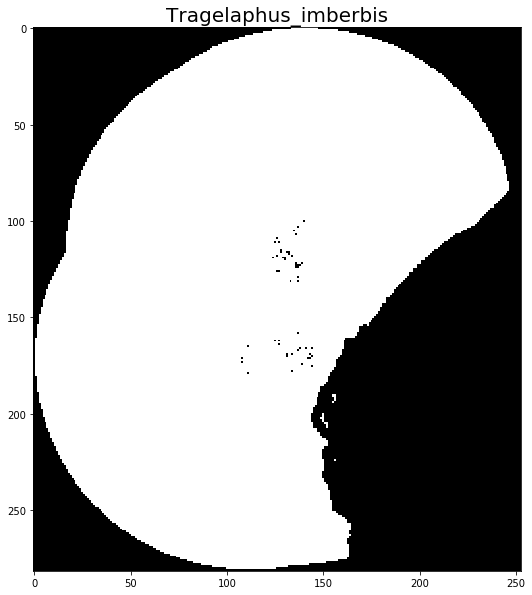

61 number of presences
1000 number of pseudo absences
1061 lenght data with pseudo absences pre-filtering
1039 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragelaphus_scriptus')

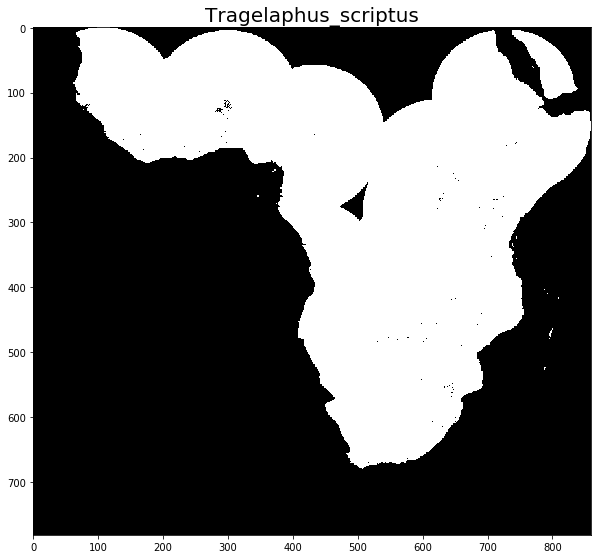

583 number of presences
1000 number of pseudo absences
1583 lenght data with pseudo absences pre-filtering
1549 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragelaphus_spekii')

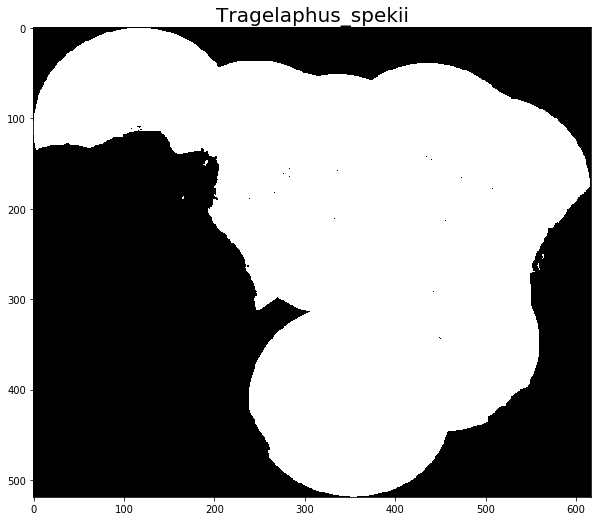

44 number of presences
1000 number of pseudo absences
1044 lenght data with pseudo absences pre-filtering
1035 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragelaphus_strepsiceros')

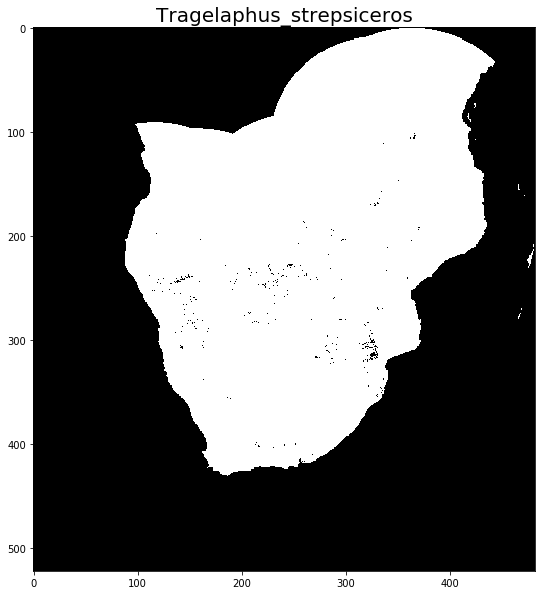

573 number of presences
1000 number of pseudo absences
1573 lenght data with pseudo absences pre-filtering
1535 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragulus_javanicus')

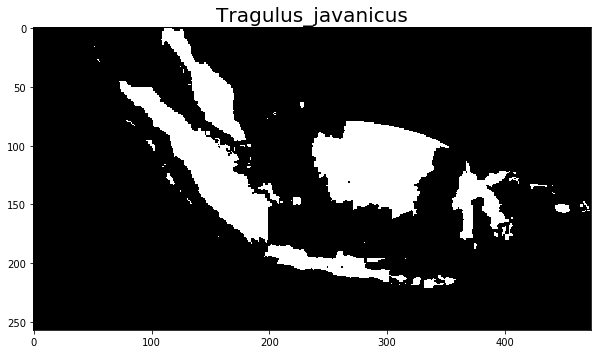

11 number of presences
1000 number of pseudo absences
1011 lenght data with pseudo absences pre-filtering
1005 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragulus_kanchil')

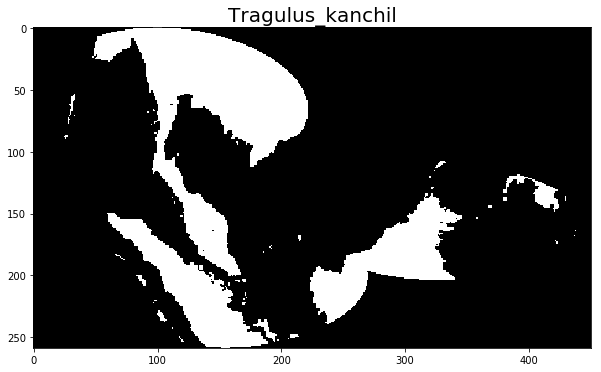

14 number of presences
1000 number of pseudo absences
1014 lenght data with pseudo absences pre-filtering
1014 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Tragulus_napu')

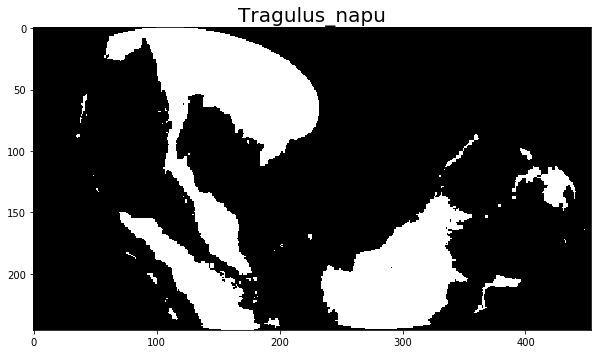

13 number of presences
1000 number of pseudo absences
1013 lenght data with pseudo absences pre-filtering
1011 length data with pseudo absences post-filtering


Text(0.5, 1.0, 'Vicagna_vicugna')

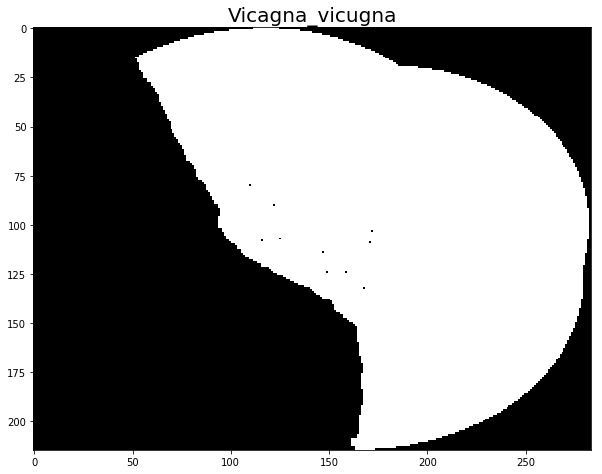

12 number of presences
1000 number of pseudo absences
1012 lenght data with pseudo absences pre-filtering
1009 length data with pseudo absences post-filtering


In [30]:
for key in species_occ_dict:    
    #lon_lat presence points
    presence_data = species_occ_dict[key]
    presence_data["present/pseudo_absent"]=1
    spec = key
    long=presence_data["decimal_longitude"]
    lati=presence_data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)
   
    
    
    #read raster
    src=rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array=src.read_masks(1)
    
    #set raster cell mask values of presence locations to 1
    for i in range(0,len(presence_data)):
        row,col=src.index(long[i],lati[i])
        array[row,col]=1
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array,cmap="gray")
    ax.set_title("%s"%spec,
             fontsize=20)
    plt.show()
    print(len(presence_data), "number of presences")
    
    (y_index, x_index) = np.nonzero(array > 1)

    #sample random locations from raster excluding sea and presence cells
    r = gdal.Open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point


    lon_lat_array=np.stack((x_coords,y_coords)).T

    random_sample_size=1000
    random_sample_lon_lats=lon_lat_array[np.random.choice(lon_lat_array.shape[0], 1000, replace=False), :] ##
    print(len(random_sample_lon_lats), "number of pseudo absences")

    #Add random points to dataset
    lon=[]
    lat=[]
    psa=[0]*random_sample_size
    taxon=["%s"%spec]*random_sample_size
    gbif=["no_id"]*random_sample_size

    for item in random_sample_lon_lats:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)

    ###Dataset including 10.000 pseudo-absence points for capriolus capriolus
    new_data=pd.DataFrame({"gbif_id": gbif,"taxon_name":taxon,"decimal_longitude": lon, "decimal_latitude":lat, "present/pseudo_absent": psa})
    data=pd.concat([presence_data,new_data],ignore_index=True)
    data=data[['taxon_name','gbif_id','decimal_longitude','decimal_latitude','present/pseudo_absent']]
    data["row_n"]=np.arange(len(data))
     
    long=data["decimal_longitude"]
    lati=data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)
    
    print(len(data),"lenght data with pseudo absences pre-filtering")
    
    #read raster
    src=rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array=src.read_masks(1)
    
    ##remove potential presence locations in the sea##
    for i in range(1,42):
        array=src.read_masks(i)
        for i in range(0,len(data)):
            row,col=src.index(long[i],lati[i])
            if array[row,col] ==0:
                data=data[data.row_n != i]     
    print(len(data), "length data with pseudo absences post-filtering")
    
    
    data=data.reset_index(drop=True)
    data.to_csv(file_dir + "/data/spec_occ/%s_occ_dataframe.csv"%spec)


In [33]:
data=pd.read_csv(file_dir+'/data/spec_occ_env/Vicagna_vicugna_env_dataframe.csv')
data

,Unnamed: 0,Unnamed: 0.1,taxon_name,gbif_id,decimal_longitude,decimal_latitude,present/pseudo_absent,band 1,band 2,band 3,...,band 32,band 33,band 34,band 35,band 36,band 37,band 38,band 39,band 40,band 41
0,0,0,Vicagna vicugna,1323889821,-74.399000,-14.721000,1,3.607876,121.0,9.0,...,548.0,9.0,164.0,78.0,1239.0,158.0,-52.0,210.0,75.0,44.0
1,1,1,Vicagna vicugna,1211821788,-69.833333,-14.833333,1,3.890819,119.0,21.0,...,356.0,19.0,154.0,69.0,1669.0,153.0,-70.0,223.0,72.0,32.0
2,2,2,Vicagna vicugna,1211820141,-74.883333,-12.366667,1,0.253220,131.0,16.0,...,227.0,51.0,150.0,76.0,885.0,180.0,-15.0,195.0,99.0,81.0
3,3,3,Vicagna vicugna,1145683553,-70.833333,-16.033333,1,1.396763,114.0,13.0,...,397.0,11.0,172.0,72.0,1790.0,121.0,-115.0,236.0,37.0,-10.0
4,4,4,Vicagna vicugna,1145683502,-69.734260,-14.254660,1,1.285963,142.0,8.0,...,362.0,28.0,159.0,68.0,1670.0,136.0,-97.0,233.0,52.0,11.0
5,5,5,Vicagna vicugna,1065388765,-74.383333,-14.666667,1,3.607876,121.0,9.0,...,548.0,9.0,164.0,78.0,1239.0,158.0,-52.0,210.0,75.0,44.0
6,6,6,Vicagna vicugna,665881183,-71.766663,-15.200000,1,0.864313,122.0,14.0,...,426.0,14.0,178.0,69.0,1830.0,150.0,-106.0,256.0,51.0,5.0
7,7,7,Vicagna vicugna,665805290,-71.583336,-16.066666,1,4.494966,122.0,14.0,...,172.0,4.0,177.0,75.0,1443.0,188.0,-45.0,233.0,99.0,68.0
8,8,8,Vicagna vicugna,476848905,-73.893589,-13.227661,1,2.061578,119.0,21.0,...,228.0,45.0,163.0,77.0,1029.0,228.0,17.0,211.0,132.0,113.0
9,9,9,Vicagna vicugna,476848904,-70.066667,-16.683333,1,2.925528,114.0,13.0,...,408.0,15.0,163.0,72.0,1800.0,110.0,-115.0,225.0,30.0,-11.0


#### Part 3 
- finally we can extract the environmental variable values underneath the occurrence and pseudo-absence points
- below is a code snippet, but because it requires a long time to run in jupyter the process is bsest split (see extract_env_variables1-4.py files)

In [ ]:
##Subset the dataframe into four parts
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/spec_filtered/taxa.txt",header=None)
taxa.columns=["taxon"]
taxa1=taxa[0:35]
taxa2=taxa[35:80]
taxa3=taxa[80:120]
taxa4=taxa[120:154]

In [ ]:
#Loop1
for i in taxa1["taxon"]:
    data = pd.read_csv(file_dir+"/data/spec_occ/%s_occ_dataframe.csv"%i)
    spec = data["taxon_name"][0]
    spec = spec.replace(" ","_")
    src = rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)

     # extract longitude and latitude and store them in normal list (as opposed to pandas Series)
    lon = data["decimal_longitude"]
    lat = data["decimal_latitude"]
    lat = pd.Series.tolist(lat)
    lon = pd.Series.tolist(lon)
    print("processing species %s" % spec)

    # go through bands iteratively
    for i in range(1, 42):
        array = src.read(i)
        band_name = "band %s" % i
        data[band_name] = None
        print("processing band %s" % i)
        for j in range(0, len(data)):
            # What is the corresponding row and column in our image?
            row, col = src.index(lon[j], lat[j])  # spatial --> image coordinates
            # print(f'row,col=\t\t({row},{col})')
            # What is the value?
            value = array[row, col]
            data[band_name][j] = value
    data.to_csv(file_dir + "/data/species_occ_env/%s_env_dataframe.csv" % spec)
### and the same is repeated for taxa 2, taxa 3, taxa 4

experimental code, check whether keeping this is necessary later

In [ ]:
 ###Dataset of world map including all locations with data-values (to later predict presence-pseudoabsence on)
    src=rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
    array=src.read_masks(1)
    
    r = gdal.Open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
    (y_index, x_index) = np.nonzero(array > 0)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point

    lon_lat_array=np.stack((x_coords,y_coords)).T

    lon=[]
    lat=[]

    for item in lon_lat_array:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)

    taxon=["%s"%spec]*len(lon)

    data_to_pred=pd.DataFrame({"decimal_longitude":lon,"decimal_latitude":lat})
    print(len(data_to_pred), "number of points to predict")
    data_to_pred.to_csv(file_dir + "/data/GIS/world_locations_to_predict.csv")


In [ ]:
data=pd.read_csv(file_dir + "/data/GIS/world_locations_to_predict.csv")
data